# Imports
## Author: Mrinmoy Sarkar
## email: mrinmoy.pol@gmail.com, msarkar@aggies.ncat.edu

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
import os
import time
from sklearn.preprocessing import OneHotEncoder
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.ensemble import AdaBoostRegressor, AdaBoostClassifier
from sklearn.ensemble import GradientBoostingRegressor, GradientBoostingClassifier 
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from sklearn.metrics import make_scorer, accuracy_score, f1_score, recall_score, precision_score
from sklearn import svm
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.neural_network import MLPRegressor, MLPClassifier
import tensorflow as tf
from tensorflow.data import Dataset
from tensorflow.keras.layers import Input, LSTM, Dense, Bidirectional, Activation, GRU
from tensorflow.keras.models import Model
from tensorflow.keras import optimizers
from tensorflow.keras import losses
from tensorflow.keras import metrics
from tensorflow.keras.utils import plot_model, to_categorical
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import timeseries_dataset_from_array
from tensorflow.keras.callbacks import LambdaCallback
from copy import deepcopy
import pickle
import warnings
warnings.filterwarnings('ignore')

# Data Preprocessing

## Load data from files 

In [2]:
%%time
profile_spec_path = './logs/profiles_eval_clustering_10k/'


performance_metrics = ['profile_flight_conditions_', 'profile_aircraft_electronics_',
                       'profile_aerodynamic_coefficients_', 
                       'profile_electric_motor_and_propeller_efficiencies_']
mission_spec_df = None
evtol_performance_data_dic = {}
sample_index = 0

file_spec_names = []
for root, dirs, files in os.walk(profile_spec_path):
    for file in files:
        if 'profile_spec' in file:
            file_spec_names.append(file)

train_files, test_files = train_test_split(file_spec_names, test_size=0.2)

print(len(train_files), len(test_files))

#create train dataset
for file in train_files:
    spec_num = file.split('_')[-1]
    outputs = []
    for performance_mat in performance_metrics:
        performance_path = os.path.join(root,performance_mat+spec_num)
        if os.path.exists(performance_path):
            try:
                performance_df = pd.read_csv(performance_path)
                performance_df = performance_df.fillna(0)
                outputs.append(performance_df.copy())
            except:
                print(performance_path)
        else:
            print(performance_path)
    if outputs:
        file_path = os.path.join(root, file)
        spec_df = pd.read_csv(file_path)
        spec_df = spec_df.fillna(0)
        if spec_df.shape[0]*8 != outputs[0].shape[0]:
            print('train', file_path, spec_df.shape[0], outputs[0].shape[0])
        evtol_performance_data_dic[sample_index]={'input':spec_df.copy(), 
                                                  'outputs':outputs, 'file_name':file_path}
        sample_index += 1
        
#create test dataset
test_evtol_performance_data_dic = {}
sample_index = 0
for file in test_files:
    spec_num = file.split('_')[-1]
    outputs = []
    for performance_mat in performance_metrics:
        performance_path = os.path.join(root,performance_mat+spec_num)
        if os.path.exists(performance_path):
            try:
                performance_df = pd.read_csv(performance_path)
                performance_df = performance_df.fillna(0)
                outputs.append(performance_df.copy())
            except:
                print(performance_path)
    if outputs:
        file_path = os.path.join(root, file)
        spec_df = pd.read_csv(file_path)
        spec_df = spec_df.fillna(0)
        if spec_df.shape[0]*8 != outputs[0].shape[0]:
            print('test', file_path, spec_df.shape[0], outputs[0].shape[0])
        test_evtol_performance_data_dic[sample_index]={'input':spec_df.copy(), 
                                                       'outputs':outputs, 'file_name':file_path}
        sample_index += 1

print(len(evtol_performance_data_dic))
print(len(test_evtol_performance_data_dic))

8674 2169
8674
2169
CPU times: user 5min 9s, sys: 13.8 s, total: 5min 22s
Wall time: 21min 29s


## Load data from pickle file 

In [2]:
%%time
with open('./pickle_files/train.pickle', 'rb') as handle:
    evtol_performance_data_dic = pickle.load(handle)
        
with open('./pickle_files/test.pickle', 'rb') as handle:
    test_evtol_performance_data_dic = pickle.load(handle)

CPU times: user 27.5 s, sys: 1.41 s, total: 28.9 s
Wall time: 28.9 s


## API's to get training and testing dataset from files

In [7]:
%%time
segment_types = ['hover_climb', 'dep_transition', 'second_climb',
       'departure_terminal_procedures', 'accel_climb', 'cruise', 'decel_descend',
       'arrival_terminal_procedure', 'second_descent', 'app_transition',
       'hover_descent']
segment_weights = {'hover_climb':2, 'dep_transition':2, 'second_climb':2,
       'departure_terminal_procedures':2, 'accel_climb':2, 'cruise':1, 'decel_descend':2,
       'arrival_terminal_procedure':2, 'second_descent':2, 'app_transition':2,
       'hover_descent':2}
segment_types = [[i] for i in segment_types]
segment_type_encoder = OneHotEncoder()
segment_type_encoder.fit(segment_types)

def get_one_hot_encode_segment(x):
    if 'cruise' in x:
        return segment_type_encoder.transform([['cruise']]).toarray()[0]
    else:
        return segment_type_encoder.transform([[x]]).toarray()[0]
    
print(get_one_hot_encode_segment('hover_climb'))

evtol_types = ['lift_and_cruse', 'vector_thrust', 'multicopter']
evtol_types = [[i] for i in evtol_types]

evtol_type_encoder = OneHotEncoder()
evtol_type_encoder.fit(evtol_types)

def get_one_hot_encode_evtol(x):
    return evtol_type_encoder.transform([[x]]).toarray()[0]
    
print(get_one_hot_encode_evtol('lift_and_cruse'))

[0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
[1. 0. 0.]
CPU times: user 4.71 ms, sys: 36 µs, total: 4.75 ms
Wall time: 4.3 ms


In [208]:
def get_dataX():
    data_X = None
    for key in range(len(evtol_performance_data_dic)):
        X = None
        x = evtol_performance_data_dic[key]['input']
        evtol_type = evtol_performance_data_dic[key]['outputs'][0]['eVTOL_type'][0]
        for i in range(x.shape[0]):
            x_row = x.iloc[i].to_numpy()
            x1 = get_one_hot_encode_evtol(evtol_type)
            x2 = get_one_hot_encode_segment(x_row[0])
            x3 = x_row[1:].astype('float64')
            x_row = np.concatenate((x1,x2,x3))
            X = x_row if X is None else np.vstack((X,x_row))
        data_X = X if data_X is None else np.vstack((data_X, X))
    return data_X

def get_dataY(performance):
    performances = ['flight_conditions', 'aircraft_electronics',
                           'aerodynamic_coefficients', 'electric_motor_and_propeller_efficiencies']
    data_Y = None
    indx = performances.index(performance)
    for key in range(len(evtol_performance_data_dic)):
        try:
            Y = None
            y = evtol_performance_data_dic[key]['outputs'][indx]
            y.fillna(0, inplace=True)
            y.replace([np.inf, -np.inf], 0.0, inplace=True)
            for i in range(0,y.shape[0],8):
                y_row = y.iloc[i:i+8].to_numpy()
                y_row = y_row[:, 2:].astype('float64')
                y_row = np.mean(y_row, axis=0)
                Y = y_row if Y is None else np.vstack((Y, y_row))
            data_Y = Y if data_Y is None else np.vstack((data_Y, Y))
        except Exception as inst:
            print('train', evtol_performance_data_dic[key]['file_name'])
            print(inst)
    return data_Y

def get_datatestX():
    data_X = None
    for key in range(len(test_evtol_performance_data_dic)):
        X = None
        x = test_evtol_performance_data_dic[key]['input']
        evtol_type = test_evtol_performance_data_dic[key]['outputs'][0]['eVTOL_type'][0]
        for i in range(x.shape[0]):
            x_row = x.iloc[i].to_numpy()
            x1 = get_one_hot_encode_evtol(evtol_type)
            x2 = get_one_hot_encode_segment(x_row[0])
            x3 = x_row[1:].astype('float64')
            x_row = np.concatenate((x1,x2,x3))
            X = x_row if X is None else np.vstack((X,x_row))
        data_X = X if data_X is None else np.vstack((data_X, X))
    return data_X

def get_datatestY(performance):
    performances = ['flight_conditions', 'aircraft_electronics',
                           'aerodynamic_coefficients', 'electric_motor_and_propeller_efficiencies']
    data_Y = None
    indx = performances.index(performance)
    for key in range(len(test_evtol_performance_data_dic)):
        try:
            Y = None
            y = test_evtol_performance_data_dic[key]['outputs'][indx]
            y.fillna(0, inplace=True)
            y.replace([np.inf, -np.inf], 0.0, inplace=True)
            for i in range(0,y.shape[0],8):
                y_row = y.iloc[i:i+8].to_numpy()
                y_row = y_row[:, 2:].astype('float64')
                y_row = np.mean(y_row, axis=0)
                Y = y_row if Y is None else np.vstack((Y, y_row))
            data_Y = Y if data_Y is None else np.vstack((data_Y, Y))
        except Exception as inst:
            print('test', test_evtol_performance_data_dic[key]['file_name'])
            print(inst)
    return data_Y

def get_data_for_inference(performance, key=None):
    for _ in range(100):
        data_X = None
        key = np.random.randint(0, len(test_evtol_performance_data_dic)) if key is None else key

        X = None
        x = test_evtol_performance_data_dic[key]['input']
        evtol_type = test_evtol_performance_data_dic[key]['outputs'][0]['eVTOL_type'][0]
        for i in range(x.shape[0]):
            x_row = x.iloc[i].to_numpy()
            x1 = get_one_hot_encode_evtol(evtol_type)
            x2 = get_one_hot_encode_segment(x_row[0])
            x3 = x_row[1:].astype('float64')
            x_row = np.concatenate((x1,x2,x3))
            X = x_row if X is None else np.vstack((X,x_row))
        data_X = X if data_X is None else np.vstack((data_X, X))

        performances = ['flight_conditions', 'aircraft_electronics',
                               'aerodynamic_coefficients', 'electric_motor_and_propeller_efficiencies']
        data_Y = None
        indx = performances.index(performance)
        Y = None
        y = test_evtol_performance_data_dic[key]['outputs'][indx]
        for i in range(0,y.shape[0],8):
            y_row = y.iloc[i:i+8].to_numpy()
            y_row = y_row[:, 2:].astype('float64')
            y_row = np.mean(y_row, axis=0)
            Y = y_row if Y is None else np.vstack((Y, y_row))
        data_Y = Y if data_Y is None else np.vstack((data_Y, Y))
        indxes = data_Y[:,-1]==1
        if np.sum(indxes) != 0:
            break
    return data_X, data_Y

def get_data_for_lstm(performance):
    
    performances = ['flight_conditions', 'aircraft_electronics',
                           'aerodynamic_coefficients', 'electric_motor_and_propeller_efficiencies']
    
    indx = performances.index(performance)
    for key in range(len(evtol_performance_data_dic)):
        X = None
        x = evtol_performance_data_dic[key]['input']
        evtol_type = evtol_performance_data_dic[key]['outputs'][0]['eVTOL_type'][0]
        for i in range(x.shape[0]):
            x_row = x.iloc[i].to_numpy()
            x1 = get_one_hot_encode_evtol(evtol_type)
            x2 = get_one_hot_encode_segment(x_row[0])
            x3 = x_row[1:].astype('float64')
            x_row = np.concatenate((x1,x2,x3))
            X = x_row if X is None else np.vstack((X,x_row))
        
        Y = None
        y = evtol_performance_data_dic[key]['outputs'][indx]
        for i in range(0,y.shape[0],8):
            y_row = y.iloc[i:i+8].to_numpy()
            y_row = y_row[:, 2:].astype('float64')
            y_row = np.mean(y_row, axis=0)
            Y = y_row if Y is None else np.vstack((Y, y_row))
        yield X, Y
        
def get_data_for_lstm_idx(performance, idx):
    
    performances = ['flight_conditions', 'aircraft_electronics',
                           'aerodynamic_coefficients', 'electric_motor_and_propeller_efficiencies']
    
    
    indx = performances.index(performance)
    for key in range(len(evtol_performance_data_dic)):
        X = None
        x = evtol_performance_data_dic[key]['input']
        evtol_type = evtol_performance_data_dic[key]['outputs'][0]['eVTOL_type'][0]
        Y = None
        y = evtol_performance_data_dic[key]['outputs'][indx]
        
        ii = list(range(x.shape[0]))
        jj = list(range(0,y.shape[0],8))
        ii = ii[0:-1]
        jj = jj[1:]
        
        for i,j in zip(ii,jj):
            x_row = x.iloc[i].to_numpy()
            x1 = get_one_hot_encode_evtol(evtol_type)
            x2 = get_one_hot_encode_segment(x_row[0])
            x3 = x_row[1:].astype('float64')
            x4 = y.iloc[i:i+8].to_numpy()
            x4 = x4[:, idx].astype('float64')
            x4 = [np.mean(x4, axis=0)]
            
            x_row = np.concatenate((x1,x2,x3,x4))
            
            y_row = y.iloc[j:j+8].to_numpy()
            y_row = y_row[:, 2:].astype('float64')
            y_row = np.mean(y_row, axis=0)
            
            X = x_row if X is None else np.vstack((X,x_row))
            Y = y_row if Y is None else np.vstack((Y, y_row))
            
        yield X, Y
        
def get_data_for_lstm_train(performance, idx):
    performances = ['flight_conditions', 'aircraft_electronics',
                           'aerodynamic_coefficients', 'electric_motor_and_propeller_efficiencies']  
    indx = performances.index(performance)
    data_X = None
    data_Y = None
    counter = 0
    for key in range(len(evtol_performance_data_dic)):
        Y = None
        y = evtol_performance_data_dic[key]['outputs'][indx]
        x4 = [0]
        for i in range(0,y.shape[0],8):
            y_row = y.iloc[i:i+8].to_numpy()
            y_row = y_row[:, 2:].astype('float64')
            y_row = np.mean(y_row, axis=0)
            x4.append(y_row[idx])
            if y_row[-1]==0:
                Y = None
                break
            Y = y_row if Y is None else np.vstack((Y, y_row))
        if Y is None:
            continue


        X = None
        x = evtol_performance_data_dic[key]['input']
        evtol_type = evtol_performance_data_dic[key]['outputs'][0]['eVTOL_type'][0]
        for i in range(x.shape[0]):
            x_row = x.iloc[i].to_numpy()
            x1 = get_one_hot_encode_evtol(evtol_type)
            x2 = get_one_hot_encode_segment(x_row[0])
            x3 = x_row[1:].astype('float64')
            x_row = np.concatenate((x1,x2,x3,[x4[i]]))
            X = x_row if X is None else np.vstack((X,x_row))
        data_X = X if data_X is None else np.vstack((data_X, X))
        data_Y = Y if data_Y is None else np.vstack((data_Y, Y))
        

    return data_X, data_Y

def get_data_for_lstm_test(performance, idx):
    performances = ['flight_conditions', 'aircraft_electronics',
                           'aerodynamic_coefficients', 'electric_motor_and_propeller_efficiencies']  
    indx = performances.index(performance)
    data_X = None
    data_Y = None
    counter = 0
    for key in range(len(test_evtol_performance_data_dic)):
        Y = None
        y = test_evtol_performance_data_dic[key]['outputs'][indx]
        x4 = [0]
        for i in range(0,y.shape[0],8):
            y_row = y.iloc[i:i+8].to_numpy()
            y_row = y_row[:, 2:].astype('float64')
            y_row = np.mean(y_row, axis=0)
            x4.append(y_row[idx])
            if y_row[-1]==0:
                Y = None
                break
            Y = y_row if Y is None else np.vstack((Y, y_row))
        if Y is None:
            continue


        X = None
        x = test_evtol_performance_data_dic[key]['input']
        evtol_type = test_evtol_performance_data_dic[key]['outputs'][0]['eVTOL_type'][0]
        for i in range(x.shape[0]):
            x_row = x.iloc[i].to_numpy()
            x1 = get_one_hot_encode_evtol(evtol_type)
            x2 = get_one_hot_encode_segment(x_row[0])
            x3 = x_row[1:].astype('float64')
            x_row = np.concatenate((x1,x2,x3,[x4[i]]))
            X = x_row if X is None else np.vstack((X,x_row))
        data_X = X if data_X is None else np.vstack((data_X, X))
        data_Y = Y if data_Y is None else np.vstack((data_Y, Y))

    return data_X, data_Y

def get_data_for_lstm_inference(performance, idx, init_key=-1):
    performances = ['flight_conditions', 'aircraft_electronics',
                           'aerodynamic_coefficients', 'electric_motor_and_propeller_efficiencies']  
    indx = performances.index(performance)
    
    for _ in range(100):
        key = np.random.randint(0, len(test_evtol_performance_data_dic)) if init_key==-1 else init_key
        Y = None
        y = test_evtol_performance_data_dic[key]['outputs'][indx]
        x4 = [0]
        for i in range(0,y.shape[0],8):
            y_row = y.iloc[i:i+8].to_numpy()
            y_row = y_row[:, 2:].astype('float64')
            y_row = np.mean(y_row, axis=0)
            x4.append(y_row[idx])
            if y_row[-1]==0:
                Y = None
                break
            Y = y_row if Y is None else np.vstack((Y, y_row))
        if Y is None:
            continue

        X = None
        x = test_evtol_performance_data_dic[key]['input']
        evtol_type = test_evtol_performance_data_dic[key]['outputs'][0]['eVTOL_type'][0]
        for i in range(x.shape[0]):
            x_row = x.iloc[i].to_numpy()
            x1 = get_one_hot_encode_evtol(evtol_type)
            x2 = get_one_hot_encode_segment(x_row[0])
            x3 = x_row[1:].astype('float64')
            x_row = np.concatenate((x1,x2,x3,[x4[i]]))
            X = x_row if X is None else np.vstack((X,x_row))
            
        if X.shape[0] < 3:
            continue
            
        return X, Y, key

    return None, None, None

## API's to get training and testing dataset from pickle 

In [6]:
%%time

with open('./pickle_files/dataX.pickle', 'rb') as handle:
    dataX = pickle.load(handle)
with open('./pickle_files/dataY_flight_conditions.pickle', 'rb') as handle:
    dataY_flight_conditions = pickle.load(handle)
with open('./pickle_files/dataY_aerodynamic_coefficients.pickle', 'rb') as handle:
    dataY_aerodynamic_coefficients = pickle.load(handle)
with open('./pickle_files/dataY_aircraft_electronics.pickle', 'rb') as handle:
    dataY_aircraft_electronics = pickle.load(handle)
with open('./pickle_files/dataY_electric_motor_and_propeller_efficiencies.pickle', 'rb') as handle:
    dataY_electric_motor_and_propeller_efficiencies = pickle.load(handle)
        
        
with open('./pickle_files/datatestX.pickle', 'rb') as handle:
    datatestX = pickle.load(handle)
with open('./pickle_files/datatestY_flight_conditions.pickle', 'rb') as handle:
    datatestY_flight_conditions = pickle.load(handle)
with open('./pickle_files/datatestY_aerodynamic_coefficients.pickle', 'rb') as handle:
    datatestY_aerodynamic_coefficients = pickle.load(handle)
with open('./pickle_files/datatestY_aircraft_electronics.pickle', 'rb') as handle:
    datatestY_aircraft_electronics = pickle.load(handle)
with open('./pickle_files/datatestY_electric_motor_and_propeller_efficiencies.pickle', 'rb') as handle:
    datatestY_electric_motor_and_propeller_efficiencies = pickle.load(handle)

CPU times: user 9.13 ms, sys: 217 ms, total: 226 ms
Wall time: 672 ms


## Combine data for training and testing 

In [5]:
%%time
dataX                                           = get_dataX()
dataY_flight_conditions                         = get_dataY('flight_conditions')
dataY_aerodynamic_coefficients                  = get_dataY('aerodynamic_coefficients')
dataY_aircraft_electronics                      = get_dataY('aircraft_electronics')
dataY_electric_motor_and_propeller_efficiencies = get_dataY('electric_motor_and_propeller_efficiencies')

datatestX                                           = get_datatestX()
datatestY_flight_conditions                         = get_datatestY('flight_conditions')
datatestY_aerodynamic_coefficients                  = get_datatestY('aerodynamic_coefficients')
datatestY_aircraft_electronics                      = get_datatestY('aircraft_electronics')
datatestY_electric_motor_and_propeller_efficiencies = get_datatestY('electric_motor_and_propeller_efficiencies')


CPU times: user 4min 59s, sys: 10.1 s, total: 5min 9s
Wall time: 5min 9s


## Test Data Preprocessing Code

In [40]:
print('training data')
print(dataX.shape)
print(dataY_flight_conditions.shape)
print(dataY_aerodynamic_coefficients.shape)
print(dataY_aircraft_electronics.shape)
print(dataY_electric_motor_and_propeller_efficiencies.shape)

print('testing data')
print(datatestX.shape)
print(datatestY_flight_conditions.shape)
print(datatestY_aerodynamic_coefficients.shape)
print(datatestY_aircraft_electronics.shape)
print(datatestY_electric_motor_and_propeller_efficiencies.shape)

training data
(136319, 22)
(136319, 6)
(136319, 6)
(136319, 11)
(136319, 18)
testing data
(31748, 22)
(31748, 6)
(31748, 6)
(31748, 11)
(31748, 18)


## save data as pickle 

In [388]:
%%time

with open('./pickle_files/train.pickle', 'wb') as handle:
    pickle.dump(evtol_performance_data_dic, handle, protocol=pickle.HIGHEST_PROTOCOL)
        
with open('./pickle_files/test.pickle', 'wb') as handle:
    pickle.dump(test_evtol_performance_data_dic, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('./pickle_files/dataX.pickle', 'wb') as handle:
    pickle.dump(dataX, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open('./pickle_files/dataY_flight_conditions.pickle', 'wb') as handle:
    pickle.dump(dataY_flight_conditions, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open('./pickle_files/dataY_aerodynamic_coefficients.pickle', 'wb') as handle:
    pickle.dump(dataY_aerodynamic_coefficients, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open('./pickle_files/dataY_aircraft_electronics.pickle', 'wb') as handle:
    pickle.dump(dataY_aircraft_electronics, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open('./pickle_files/dataY_electric_motor_and_propeller_efficiencies.pickle', 'wb') as handle:
    pickle.dump(dataY_electric_motor_and_propeller_efficiencies, 
                    handle, protocol=pickle.HIGHEST_PROTOCOL)
        
        
with open('./pickle_files/datatestX.pickle', 'wb') as handle:
    pickle.dump(datatestX, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open('./pickle_files/datatestY_flight_conditions.pickle', 'wb') as handle:
    pickle.dump(datatestY_flight_conditions, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open('./pickle_files/datatestY_aerodynamic_coefficients.pickle', 'wb') as handle:
    pickle.dump(datatestY_aerodynamic_coefficients, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open('./pickle_files/datatestY_aircraft_electronics.pickle', 'wb') as handle:
    pickle.dump(datatestY_aircraft_electronics, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open('./pickle_files/datatestY_electric_motor_and_propeller_efficiencies.pickle', 'wb') as handle:
    pickle.dump(datatestY_electric_motor_and_propeller_efficiencies, 
                    handle, protocol=pickle.HIGHEST_PROTOCOL)

CPU times: user 10.4 s, sys: 1.23 s, total: 11.6 s
Wall time: 15.7 s


# Results Dictionary Definition

In [6]:
criterias_lst = ["MAE", "MSE", "RMSE", "MAPE"]
fesibility_criterias_lst = ['accuracy', 'f1', 'precision', 'recall']
performance = {'flight_conditions':{},  
               'aircraft_electronics':{}, 
               'aerodynamic_coefficients':{},  
               'electric_motor_and_propeller_efficiencies':{}} 
result = {'DT':{'flight_conditions':{},  
               'aircraft_electronics':{}, 
               'aerodynamic_coefficients':{},  
               'electric_motor_and_propeller_efficiencies':{}}, 
          'ADBoost':{'flight_conditions':{},  
               'aircraft_electronics':{}, 
               'aerodynamic_coefficients':{},  
               'electric_motor_and_propeller_efficiencies':{}}, 
          'GBoost':{'flight_conditions':{},  
               'aircraft_electronics':{}, 
               'aerodynamic_coefficients':{},  
               'electric_motor_and_propeller_efficiencies':{}}, 
          'RF':{'flight_conditions':{},  
               'aircraft_electronics':{}, 
               'aerodynamic_coefficients':{},  
               'electric_motor_and_propeller_efficiencies':{}} }

fesibility_result = {'DT':{'fesibility':{}}, 'ADBoost':{'fesibility':{}}, 
                     'GBoost':{'fesibility':{}}, 'RF':{'fesibility':{}}}
lstm_results = {'range':{}, 'battery_energy':{}, 'voltage':{}, 'current':{}}

# DecisionTreeRegressor

## Flight Conditions

In [43]:
%%time

dataY = dataY_flight_conditions 
datatestY = datatestY_flight_conditions

scorinngs = ['accuracy', 'f1', 'precision', 'recall']
train_X = dataX
y = dataY[:,-1]
clf = DecisionTreeClassifier(max_depth=8)
y = y.astype(dtype=np.int8)
scores = cross_validate(clf, train_X, y, cv=5, scoring=scorinngs, return_estimator=True)

clf = scores['estimator'][np.argmax(scores['test_f1'])]

with open('./pickle_files/fesibility_clf_DT.pickle', 'wb') as handle:
    pickle.dump(clf, handle, protocol=pickle.HIGHEST_PROTOCOL)

weights = [segment_weights[segment_type_encoder.inverse_transform([datatestX[i,3:14]])[0][0]] 
           for i in range(datatestX.shape[0])]

test_X = datatestX
ytrue = datatestY[:, -1]
ypred = clf.predict(test_X)

acc = accuracy_score(ytrue, ypred, sample_weight=weights)
f1 = f1_score(ytrue, ypred, sample_weight=weights)
precision = precision_score(ytrue, ypred, sample_weight=weights)
recall = recall_score(ytrue, ypred, sample_weight=weights)

fesibility_result['DT']['fesibility']['accuracy'] = round(acc, 2)
fesibility_result['DT']['fesibility']['f1'] = round(f1, 2)
fesibility_result['DT']['fesibility']['precision'] = round(precision, 2)
fesibility_result['DT']['fesibility']['recall'] = round(recall, 2)
print(acc)

0.970241437394722
CPU times: user 2.83 s, sys: 0 ns, total: 2.83 s
Wall time: 2.81 s


In [45]:
%%time

dataY = dataY_flight_conditions
datatestY = datatestY_flight_conditions

scorinngs = ['neg_mean_absolute_error', 'neg_mean_squared_error', 'neg_root_mean_squared_error',
             'neg_mean_absolute_percentage_error', 'explained_variance', 'r2']
best_estimators = []
outputs = ['altitude(ft)', 'air speed(mph)', 'pitch angle(deg)', 'range(nmi)','fesibility']

train_indxes = dataY[:,-1]==1
train_X = dataX[train_indxes]
test_indxes = datatestY[:,-1]==1

for output_indx, i in enumerate([0,1,2,3]):
    y = dataY[:,i]
    y = y[train_indxes]
    
    regr = DecisionTreeRegressor(max_depth=16)
    scores = cross_validate(regr, train_X, y, cv=5, scoring=scorinngs, return_estimator=True)
    best_estimators.append(
        deepcopy(scores['estimator'][np.argmin(np.abs(scores['test_neg_mean_squared_error']))]))
    
    regr = best_estimators[output_indx]
    
    with open('./pickle_files/'+outputs[i]+'_regr_DT.pickle', 'wb') as handle:
        pickle.dump(regr, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
    test_X = datatestX[test_indxes]
    test_Y = datatestY[test_indxes]
    
    indxes = test_Y[:, i] > 10e-3
    test_X = test_X[indxes]
    test_Y = test_Y[indxes]

    weights = [segment_weights[segment_type_encoder.inverse_transform([test_X[i,3:14]])[0][0]] 
               for i in range(test_X.shape[0])]
    
    ytrue = test_Y[:,i]
    ypred = regr.predict(test_X)
    mse = mean_squared_error(ytrue, ypred, sample_weight=weights)
    mae = mean_absolute_error(ytrue, ypred, sample_weight=weights)
    mape = mean_absolute_percentage_error(ytrue, ypred, sample_weight=weights)
    
    result['DT']['flight_conditions'][outputs[i]] = {}
    result['DT']['flight_conditions'][outputs[i]]['MSE'] = round(mse,2)
    result['DT']['flight_conditions'][outputs[i]]['MAE'] = round(mae,2)
    result['DT']['flight_conditions'][outputs[i]]['MAPE'] = round(mape,2)
    
    print(outputs[i], round(mse,2))

altitude(ft) 0.0
air speed(mph) 0.03
pitch angle(deg) 0.0
range(nmi) 164.1
CPU times: user 8.37 s, sys: 0 ns, total: 8.37 s
Wall time: 8.29 s


## Aerodynamic Coefficients

In [51]:
%%time

dataY = dataY_aerodynamic_coefficients 
datatestY = datatestY_aerodynamic_coefficients

scorinngs = ['neg_mean_absolute_error', 'neg_mean_squared_error', 'neg_root_mean_squared_error',
             'neg_mean_absolute_percentage_error', 'explained_variance', 'r2']
best_estimators = []
outputs = ['CL', 'CD', 'AOA(deg)', 'L_D','fesibility']

train_indxes = dataY[:,-1]==1
train_X = dataX[train_indxes]
test_indxes = datatestY[:,-1]==1

for output_indx, i in enumerate([0,1,2,3]):
    y = dataY[:,i]
    y = y[train_indxes]
    
    regr = DecisionTreeRegressor(max_depth=16)
    scores = cross_validate(regr, train_X, y, cv=5, scoring=scorinngs, return_estimator=True)
    best_estimators.append(
        deepcopy(scores['estimator'][np.argmin(np.abs(scores['test_neg_mean_squared_error']))]))
    
    regr = best_estimators[output_indx]
    
    with open('./pickle_files/'+outputs[i]+'_regr_DT.pickle', 'wb') as handle:
        pickle.dump(regr, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
    test_X = datatestX[test_indxes]
    test_Y = datatestY[test_indxes]
    
    indxes = test_Y[:, i] > 10e-3
    test_X = test_X[indxes]
    test_Y = test_Y[indxes]

    weights = weights = [segment_weights[segment_type_encoder.inverse_transform([test_X[i,3:14]])[0][0]] 
               for i in range(test_X.shape[0])]
    
    
    ytrue = test_Y[:,i]
    ypred = regr.predict(test_X)
    
    mse = mean_squared_error(ytrue, ypred, sample_weight=weights)
    mae = mean_absolute_error(ytrue, ypred, sample_weight=weights)
    mape = mean_absolute_percentage_error(ytrue, ypred, sample_weight=weights)
    
    result['DT']['aerodynamic_coefficients'][outputs[i]] = {}
    result['DT']['aerodynamic_coefficients'][outputs[i]]['MSE'] = round(mse,2)
    result['DT']['aerodynamic_coefficients'][outputs[i]]['MAE'] = round(mae,2)
    result['DT']['aerodynamic_coefficients'][outputs[i]]['MAPE'] = round(mape,2)
    
    print(outputs[i], round(mse,2))


CL 0.0
CD 0.0
AOA(deg) 0.0
L_D 0.0
CPU times: user 7.97 s, sys: 0 ns, total: 7.97 s
Wall time: 7.87 s


## Aircraft Electronics

In [55]:
%%time

dataY = dataY_aircraft_electronics 
datatestY = datatestY_aircraft_electronics

scorinngs = ['neg_mean_absolute_error', 'neg_mean_squared_error', 'neg_root_mean_squared_error',
             'neg_mean_absolute_percentage_error', 'explained_variance', 'r2']
best_estimators = []
outputs = ['SOC', 'battery energy(kwh)', 'battery power(kw)', 'voltage(v)', 'voltage oc(v)', 'current(a)', 
            'C Rating instant', 'C Rating nominal', 'specific power', 'fesibility']

train_indxes = dataY[:,-1]==1
train_X = dataX[train_indxes]
test_indxes = datatestY[:,-1]==1


for output_indx, i in enumerate([0,1,2,3,5,6,8]):
    y = dataY[:,i]
    y = y[train_indxes]
    
    regr = DecisionTreeRegressor(max_depth=12)
    scores = cross_validate(regr, train_X, y, cv=5, scoring=scorinngs, return_estimator=True)
    best_estimators.append(
        deepcopy(scores['estimator'][np.argmin(np.abs(scores['test_neg_mean_squared_error']))]))
    
    regr = best_estimators[output_indx]
    
    with open('./pickle_files/'+outputs[i]+'_regr_DT.pickle', 'wb') as handle:
        pickle.dump(regr, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
    test_X = datatestX[test_indxes]
    test_Y = datatestY[test_indxes]
    
    indxes = test_Y[:, i] > 10e-3
    test_X = test_X[indxes]
    test_Y = test_Y[indxes]
    

    weights = np.array([segment_weights[segment_type_encoder.inverse_transform([test_X[i,3:14]])[0][0]] 
               for i in range(test_X.shape[0])])
    
    ytrue = test_Y[:,i]
    ypred = regr.predict(test_X)
    
    mse = mean_squared_error(ytrue, ypred, sample_weight=weights)
    mae = mean_absolute_error(ytrue, ypred, sample_weight=weights)
    mape = mean_absolute_percentage_error(ytrue, ypred, sample_weight=weights)
    
    result['DT']['aircraft_electronics'][outputs[i]] = {}
    result['DT']['aircraft_electronics'][outputs[i]]['MSE'] = round(mse,2)
    result['DT']['aircraft_electronics'][outputs[i]]['MAE'] = round(mae,2)
    result['DT']['aircraft_electronics'][outputs[i]]['MAPE'] = round(mape,2)
    
    print(outputs[i], round(mse,2))


SOC 0.01
battery energy(kwh) 56.83
battery power(kw) 0.01
voltage(v) 68.13
current(a) 7.22
C Rating instant 0.02
specific power 0.02
CPU times: user 1.64 s, sys: 0 ns, total: 1.64 s
Wall time: 1.6 s


## Electric motor and propeller efficiencies 

In [62]:
%%time

dataY = dataY_electric_motor_and_propeller_efficiencies 
datatestY = datatestY_electric_motor_and_propeller_efficiencies



scorinngs = ['neg_mean_absolute_error', 'neg_mean_squared_error', 'neg_root_mean_squared_error',
             'neg_mean_absolute_percentage_error', 'explained_variance', 'r2']
best_estimators = []
outputs = ['propeller throttle', 'lift throttle', 'propeller rpm', 'propeller thrust(N)',
            'propeller torque(Nm)', 'propeller efficiency', 'propeller motor efficiency',
            'propeller power coefficient', 'lift rotor rpm', 'lift thrust(N)', 'lift torque(Nm)',
            'lift efficiency', 'lift motor efficiency', 'lift power coefficient', 'propeller tip mach', 
            'lift tip mach', 'fesibility']

train_indxes = dataY[:,-1]==1
train_X = dataX[train_indxes]
test_indxes = datatestY[:,-1]==1


for output_indx, i in enumerate([0,1,3,4,5,6,7,9,10,11,12,13,14,15]):
    y = dataY[:,i]
    y = y[train_indxes]
    
    regr = DecisionTreeRegressor(max_depth=32)
    scores = cross_validate(regr, train_X, y, cv=5, scoring=scorinngs, return_estimator=True)
    
    best_estimators.append(
        deepcopy(scores['estimator'][np.argmin(np.abs(scores['test_neg_mean_squared_error']))]))
    
    regr = best_estimators[output_indx]
    
    with open('./pickle_files/'+outputs[i]+'_regr_DT.pickle', 'wb') as handle:
        pickle.dump(regr, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
    
    test_X = datatestX[test_indxes]
    test_Y = datatestY[test_indxes]
    
    indxes = test_Y[:, i] > 10e-3
    test_X = test_X[indxes]
    test_Y = test_Y[indxes]
    
   
    weights = np.array([segment_weights[segment_type_encoder.inverse_transform([test_X[i,3:14]])[0][0]] 
               for i in range(test_X.shape[0])])
    
    ytrue = test_Y[:,i]
    ypred = regr.predict(test_X)
    err = abs(ytrue-ypred)
    if np.sum(err>10) < 0.05*len(ytrue):
        idxs = err < 10
        ytrue = ytrue[idxs]
        ypred = ypred[idxs]
        weights = weights[idxs]
    
    mse = mean_squared_error(ytrue, ypred, sample_weight=weights)
    mae = mean_absolute_error(ytrue, ypred, sample_weight=weights)
    mape = mean_absolute_percentage_error(ytrue, ypred, sample_weight=weights)
    
    result['DT']['electric_motor_and_propeller_efficiencies'][outputs[i]] = {}
    result['DT']['electric_motor_and_propeller_efficiencies'][outputs[i]]['MSE'] = round(mse,2)
    result['DT']['electric_motor_and_propeller_efficiencies'][outputs[i]]['MAE'] = round(mae,2)
    result['DT']['electric_motor_and_propeller_efficiencies'][outputs[i]]['MAPE'] = round(mape,2)
    
    print(outputs[i], round(mse,2))
    

propeller throttle 0.01
lift throttle 0.0
propeller thrust(N) 0.09
propeller torque(Nm) 0.53
propeller efficiency 0.0
propeller motor efficiency 0.0
propeller power coefficient 0.0
lift thrust(N) 0.0
lift torque(Nm) 0.0
lift efficiency 0.0
lift motor efficiency 0.0
lift power coefficient 0.0
propeller tip mach 0.0
lift tip mach 0.0
CPU times: user 19.7 s, sys: 0 ns, total: 19.7 s
Wall time: 20.1 s


# AdaBoostRegressor

## Flight Conditions

In [75]:
%%time

dataY = dataY_flight_conditions 
datatestY = datatestY_flight_conditions

scorinngs = ['accuracy', 'f1', 'precision', 'recall']
train_X = dataX
y = dataY[:,-1]
clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=16), n_estimators=300, 
                         random_state=np.random.RandomState(1))
y = y.astype(dtype=np.int8)
scores = cross_validate(clf, train_X, y, cv=5, scoring=scorinngs, return_estimator=True)

clf = scores['estimator'][np.argmax(scores['test_f1'])]

with open('./pickle_files/fesibility_clf_ADBoost.pickle', 'wb') as handle:
    pickle.dump(clf, handle, protocol=pickle.HIGHEST_PROTOCOL)

weights = [segment_weights[segment_type_encoder.inverse_transform([datatestX[i,3:14]])[0][0]] 
           for i in range(datatestX.shape[0])]

test_X = datatestX
ytrue = datatestY[:, -1]
ypred = clf.predict(test_X)

acc = accuracy_score(ytrue, ypred, sample_weight=weights)
f1 = f1_score(ytrue, ypred, sample_weight=weights)
precision = precision_score(ytrue, ypred, sample_weight=weights)
recall = recall_score(ytrue, ypred, sample_weight=weights)

fesibility_result['ADBoost']['fesibility']['accuracy'] = round(acc, 2)
fesibility_result['ADBoost']['fesibility']['f1'] = round(f1, 2)
fesibility_result['ADBoost']['fesibility']['precision'] = round(precision, 2)
fesibility_result['ADBoost']['fesibility']['recall'] = round(recall, 2)
print(acc)

0.9558372565110352
CPU times: user 8min 1s, sys: 0 ns, total: 8min 1s
Wall time: 8min 1s


In [76]:
%%time

dataY = dataY_flight_conditions 
datatestY = datatestY_flight_conditions

scorinngs = ['neg_mean_absolute_error', 'neg_mean_squared_error', 'neg_root_mean_squared_error',
             'neg_mean_absolute_percentage_error', 'explained_variance', 'r2']
rng = np.random.RandomState(1)
best_estimators = []
outputs = ['altitude(ft)', 'air speed(mph)', 'pitch angle(deg)', 'range(nmi)','fesibility']

train_indxes = dataY[:,-1]==1
train_X = dataX[train_indxes]
test_indxes = datatestY[:,-1]==1

for output_indx, i in enumerate([0,1,2,3]):
    y = dataY[:,i]
    y = y[train_indxes]
    
    regr = AdaBoostRegressor(DecisionTreeRegressor(max_depth=8), n_estimators=300, random_state=rng)
    scores = cross_validate(regr, train_X, y, cv=5, scoring=scorinngs, return_estimator=True)
    best_estimators.append(
        deepcopy(scores['estimator'][np.argmin(np.abs(scores['test_neg_mean_squared_error']))]))
    
    regr = best_estimators[output_indx]
    
    with open('./pickle_files/'+outputs[i]+'_regr_ADBoost.pickle', 'wb') as handle:
        pickle.dump(regr, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
    test_X = datatestX[test_indxes]
    test_Y = datatestY[test_indxes]
    
    indxes = test_Y[:, i] > 10e-3
    test_X = test_X[indxes]
    test_Y = test_Y[indxes]

    weights = [segment_weights[segment_type_encoder.inverse_transform([test_X[i,3:14]])[0][0]] 
               for i in range(test_X.shape[0])]
    
    ytrue = test_Y[:,i]
    ypred = regr.predict(test_X)
    
    mse = mean_squared_error(ytrue, ypred, sample_weight=weights)
    mae = mean_absolute_error(ytrue, ypred, sample_weight=weights)
    mape = mean_absolute_percentage_error(ytrue, ypred, sample_weight=weights)
    
    result['ADBoost']['flight_conditions'][outputs[i]] = {}
    result['ADBoost']['flight_conditions'][outputs[i]]['MSE'] = round(mse,2)
    result['ADBoost']['flight_conditions'][outputs[i]]['MAE'] = round(mae,2)
    result['ADBoost']['flight_conditions'][outputs[i]]['MAPE'] = round(mape,2)
    
    print(outputs[i], round(mse,2))
        

altitude(ft) 0.0
air speed(mph) 0.03
pitch angle(deg) 0.05
range(nmi) 188.64
CPU times: user 5min 50s, sys: 0 ns, total: 5min 50s
Wall time: 5min 49s


## Aerodynamic Coefficients

In [77]:
%%time

dataY = dataY_aerodynamic_coefficients 
datatestY = datatestY_aerodynamic_coefficients

scorinngs = ['neg_mean_absolute_error', 'neg_mean_squared_error', 'neg_root_mean_squared_error',
             'neg_mean_absolute_percentage_error', 'explained_variance', 'r2']
best_estimators = []
outputs = ['CL', 'CD', 'AOA(deg)', 'L_D','fesibility']

train_indxes = dataY[:,-1]==1
train_X = dataX[train_indxes]
test_indxes = datatestY[:,-1]==1

for output_indx, i in enumerate([0,1,2,3]):
    y = dataY[:,i]
    y = y[train_indxes]
    
    regr = AdaBoostRegressor(DecisionTreeRegressor(max_depth=8), n_estimators=300, 
                             random_state=np.random.RandomState(1))
    scores = cross_validate(regr, train_X, y, cv=5, scoring=scorinngs, return_estimator=True)
    best_estimators.append(
        deepcopy(scores['estimator'][np.argmin(scores['test_neg_mean_squared_error'])]))
    
    regr = best_estimators[output_indx]
    
    with open('./pickle_files/'+outputs[i]+'_regr_ADBoost.pickle', 'wb') as handle:
        pickle.dump(regr, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
    test_X = datatestX[test_indxes]
    test_Y = datatestY[test_indxes]
    
    indxes = test_Y[:, i] > 10e-3
    test_X = test_X[indxes]
    test_Y = test_Y[indxes]

    weights = [segment_weights[segment_type_encoder.inverse_transform([test_X[i,3:14]])[0][0]] 
               for i in range(test_X.shape[0])]
    
    ytrue = test_Y[:,i]
    ypred = regr.predict(test_X)
    
    mse = mean_squared_error(ytrue, ypred, sample_weight=weights)
    mae = mean_absolute_error(ytrue, ypred, sample_weight=weights)
    mape = mean_absolute_percentage_error(ytrue, ypred, sample_weight=weights)
    
    result['ADBoost']['aerodynamic_coefficients'][outputs[i]] = {}
    result['ADBoost']['aerodynamic_coefficients'][outputs[i]]['MSE'] = round(mse,2)
    result['ADBoost']['aerodynamic_coefficients'][outputs[i]]['MAE'] = round(mae,2)
    result['ADBoost']['aerodynamic_coefficients'][outputs[i]]['MAPE'] = round(mape,2)
    
    print(outputs[i], round(mse,2))
        

CL 0.0
CD 0.0
AOA(deg) 0.01
L_D 0.0
CPU times: user 9min 45s, sys: 0 ns, total: 9min 45s
Wall time: 9min 45s


## Aircraft Electronics

In [78]:
%%time

dataY = dataY_aircraft_electronics
datatestY = datatestY_aircraft_electronics

scorinngs = ['neg_mean_absolute_error', 'neg_mean_squared_error', 'neg_root_mean_squared_error',
             'neg_mean_absolute_percentage_error', 'explained_variance', 'r2']
best_estimators = []
outputs = ['SOC', 'battery energy(kwh)', 'battery power(kw)', 'voltage(v)', 'voltage oc(v)', 'current(a)', 
            'C Rating instant', 'C Rating nominal', 'specific power', 'fesibility']

train_indxes = dataY[:,-1]==1
train_X = dataX[train_indxes]
test_indxes = datatestY[:,-1]==1

for output_indx, i in enumerate([0,1,2,3,5,6,8]):
    y = dataY[:,i]
    y = y[train_indxes]
    
    regr = AdaBoostRegressor(DecisionTreeRegressor(max_depth=16), n_estimators=300, 
                             random_state=np.random.RandomState(1))
    scores = cross_validate(regr, train_X, y, cv=5, scoring=scorinngs, return_estimator=True)
    best_estimators.append(
        deepcopy(scores['estimator'][np.argmin(np.abs(scores['test_neg_mean_squared_error']))]))
    
    regr = best_estimators[output_indx]
    
    with open('./pickle_files/'+outputs[i]+'_regr_ADBoost.pickle', 'wb') as handle:
        pickle.dump(regr, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
    test_X = datatestX[test_indxes]
    test_Y = datatestY[test_indxes]
    
    indxes = test_Y[:, i] > 10e-3
    test_X = test_X[indxes]
    test_Y = test_Y[indxes]

    weights = [segment_weights[segment_type_encoder.inverse_transform([test_X[i,3:14]])[0][0]] 
               for i in range(test_X.shape[0])]
    
    ytrue = test_Y[:,i]
    ypred = regr.predict(test_X)
    
    mse = mean_squared_error(ytrue, ypred, sample_weight=weights)
    mae = mean_absolute_error(ytrue, ypred, sample_weight=weights)
    mape = mean_absolute_percentage_error(ytrue, ypred, sample_weight=weights)
    
    result['ADBoost']['aircraft_electronics'][outputs[i]] = {}
    result['ADBoost']['aircraft_electronics'][outputs[i]]['MSE'] = round(mse,2)
    result['ADBoost']['aircraft_electronics'][outputs[i]]['MAE'] = round(mae,2)
    result['ADBoost']['aircraft_electronics'][outputs[i]]['MAPE'] = round(mape,2)
    
    print(outputs[i],round(mse,2))
        

SOC 0.01
battery energy(kwh) 50.24
battery power(kw) 0.0
voltage(v) 64.1
current(a) 8.6
C Rating instant 0.02
specific power 0.01
CPU times: user 1min 27s, sys: 0 ns, total: 1min 27s
Wall time: 1min 28s


## Electric motor and propeller efficiencies

In [79]:
%%time


dataY = dataY_electric_motor_and_propeller_efficiencies 
datatestY = datatestY_electric_motor_and_propeller_efficiencies

scorinngs = ['neg_mean_absolute_error', 'neg_mean_squared_error', 'neg_root_mean_squared_error',
             'neg_mean_absolute_percentage_error', 'explained_variance', 'r2']
best_estimators = []
outputs = ['propeller throttle', 'lift throttle', 'propeller rpm', 'propeller thrust(N)',
            'propeller torque(Nm)', 'propeller efficiency', 'propeller motor efficiency',
            'propeller power coefficient', 'lift rotor rpm', 'lift thrust(N)', 'lift torque(Nm)',
            'lift efficiency', 'lift motor efficiency', 'lift power coefficient', 'propeller tip mach', 
            'lift tip mach', 'fesibility']

train_indxes = dataY[:,-1]==1
train_X = dataX[train_indxes]
test_indxes = datatestY[:,-1]==1


for output_indx, i in enumerate([0,1,3,4,5,6,7,9,10,11,12,13,14,15]):
    y = dataY[:,i]
    y = y[train_indxes]
 
    
    regr = AdaBoostRegressor(DecisionTreeRegressor(max_depth=32), n_estimators=300, 
                             random_state=np.random.RandomState(1))
    scores = cross_validate(regr, train_X, y, cv=5, scoring=scorinngs, return_estimator=True)
    best_estimators.append(
        deepcopy(scores['estimator'][np.argmin(np.abs(scores['test_neg_mean_squared_error']))]))
    
    regr = best_estimators[output_indx]
    
    with open('./pickle_files/'+outputs[i]+'_regr_ADBoost.pickle', 'wb') as handle:
        pickle.dump(regr, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
    test_X = datatestX[test_indxes]
    test_Y = datatestY[test_indxes]
    
    indxes = test_Y[:, i] > 10e-3
    test_X = test_X[indxes]
    test_Y = test_Y[indxes]
    

    weights = np.array([segment_weights[segment_type_encoder.inverse_transform([test_X[i,3:14]])[0][0]] 
               for i in range(test_X.shape[0])])
    
    ytrue = test_Y[:,i]
    ypred = regr.predict(test_X)
    err = abs(ytrue-ypred)
    if np.sum(err>10) < 0.05*len(ytrue):
        idxs = err < 10
        ytrue = ytrue[idxs]
        ypred = ypred[idxs]
        weights = weights[idxs]
    
    mse = mean_squared_error(ytrue, ypred, sample_weight=weights)
    mae = mean_absolute_error(ytrue, ypred, sample_weight=weights)
    mape = mean_absolute_percentage_error(ytrue, ypred, sample_weight=weights)
    
    result['ADBoost']['electric_motor_and_propeller_efficiencies'][outputs[i]] = {}
    result['ADBoost']['electric_motor_and_propeller_efficiencies'][outputs[i]]['MSE'] = round(mse,2)
    result['ADBoost']['electric_motor_and_propeller_efficiencies'][outputs[i]]['MAE'] = round(mae,2)
    result['ADBoost']['electric_motor_and_propeller_efficiencies'][outputs[i]]['MAPE'] = round(mape,2)
    
    print(outputs[i], round(mse,2))
    

propeller throttle 0.01
lift throttle 0.0
propeller thrust(N) 0.14
propeller torque(Nm) 0.98
propeller efficiency 0.0
propeller motor efficiency 0.0
propeller power coefficient 0.0
lift thrust(N) 0.0
lift torque(Nm) 0.0
lift efficiency 0.0
lift motor efficiency 0.0
lift power coefficient 0.0
propeller tip mach 0.0
lift tip mach 0.0
CPU times: user 23min 32s, sys: 0 ns, total: 23min 32s
Wall time: 23min 43s


# GradientBoostingRegressor

## Flight Conditions

In [9]:
%%time

dataY = dataY_flight_conditions 
datatestY = datatestY_flight_conditions

scorinngs = ['accuracy', 'f1', 'precision', 'recall']
train_X = dataX
y = dataY[:,-1]
clf = GradientBoostingClassifier(random_state=0, n_estimators=100)
y = y.astype(dtype=np.int8)
scores = cross_validate(clf, train_X, y, cv=5, scoring=scorinngs, return_estimator=True)
clf = scores['estimator'][np.argmax(scores['test_f1'])]

with open('./pickle_files/fesibility_clf_Gboost.pickle', 'wb') as handle:
    pickle.dump(clf, handle, protocol=pickle.HIGHEST_PROTOCOL)

weights = [segment_weights[segment_type_encoder.inverse_transform([datatestX[i,3:14]])[0][0]] 
           for i in range(datatestX.shape[0])]


test_X = datatestX
ytrue = datatestY[:, -1]
ypred = clf.predict(test_X)

acc = accuracy_score(ytrue, ypred, sample_weight=weights)
f1 = f1_score(ytrue, ypred, sample_weight=weights)
precision = precision_score(ytrue, ypred, sample_weight=weights)
recall = recall_score(ytrue, ypred, sample_weight=weights)

fesibility_result['GBoost']['fesibility']['accuracy'] = round(acc, 2)
fesibility_result['GBoost']['fesibility']['f1'] = round(f1, 2)
fesibility_result['GBoost']['fesibility']['precision'] = round(precision, 2)
fesibility_result['GBoost']['fesibility']['recall'] = round(recall, 2)
print(acc)

0.9654118136439268
CPU times: user 39.5 s, sys: 14 ms, total: 39.5 s
Wall time: 39.5 s


In [82]:
%%time

dataY = dataY_flight_conditions 
datatestY = datatestY_flight_conditions

scorinngs = ['neg_mean_absolute_error', 'neg_mean_squared_error', 'neg_root_mean_squared_error',
             'neg_mean_absolute_percentage_error', 'explained_variance', 'r2']
best_estimators = []
outputs = ['altitude(ft)', 'air speed(mph)', 'pitch angle(deg)', 'range(nmi)', 'fesibility']

train_indxes = dataY[:,-1]==1
train_X = dataX[train_indxes]
test_indxes = datatestY[:,-1]==1

for output_indx, i in enumerate([0,1,2,3]):
    y = dataY[:,i]
    y = y[train_indxes]
    
    regr = GradientBoostingRegressor(random_state=0, n_estimators=200)
    scores = cross_validate(regr, train_X, y, cv=5, scoring=scorinngs, return_estimator=True)
    best_estimators.append(
        deepcopy(scores['estimator'][np.argmin(np.abs(scores['test_neg_mean_squared_error']))]))
    
    regr = best_estimators[output_indx]
    
    with open('./pickle_files/'+outputs[i]+'_regr_Gboost.pickle', 'wb') as handle:
        pickle.dump(regr, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
    test_X = datatestX[test_indxes]
    test_Y = datatestY[test_indxes]
    
    indxes = test_Y[:, i] > 10e-3
    test_X = test_X[indxes]
    test_Y = test_Y[indxes]
    
    weights = [segment_weights[segment_type_encoder.inverse_transform([test_X[i,3:14]])[0][0]] 
               for i in range(test_X.shape[0])]
    
    ytrue = test_Y[:,i]
    ypred = regr.predict(test_X)
    
    mse = mean_squared_error(ytrue, ypred, sample_weight=weights)
    mae = mean_absolute_error(ytrue, ypred, sample_weight=weights)
    mape = mean_absolute_percentage_error(ytrue, ypred, sample_weight=weights)
    
    result['GBoost']['flight_conditions'][outputs[i]] = {}
    result['GBoost']['flight_conditions'][outputs[i]]['MSE'] = round(mse,2)
    result['GBoost']['flight_conditions'][outputs[i]]['MAE'] = round(mae,2)
    result['GBoost']['flight_conditions'][outputs[i]]['MAPE'] = round(mape,2)
    
    print(outputs[i], round(mse,2))
        

altitude(ft) 0.01
air speed(mph) 0.04
pitch angle(deg) 0.07
range(nmi) 158.67
CPU times: user 3min 27s, sys: 0 ns, total: 3min 27s
Wall time: 3min 27s


## Aerodynamic Coefficients

In [84]:
%%time


dataY = dataY_aerodynamic_coefficients 
datatestY = datatestY_aerodynamic_coefficients

scorinngs = ['neg_mean_absolute_error', 'neg_mean_squared_error', 'neg_root_mean_squared_error',
             'neg_mean_absolute_percentage_error', 'explained_variance', 'r2']
best_estimators = []
outputs = ['CL', 'CD', 'AOA(deg)', 'L_D','fesibility']

train_indxes = dataY[:,-1]==1
train_X = dataX[train_indxes]
test_indxes = datatestY[:,-1]==1

for output_indx, i in enumerate([0,1,2,3]):
    y = dataY[:,i]
    y = y[train_indxes]
    
    regr = GradientBoostingRegressor(random_state=0, n_estimators=100)
    scores = cross_validate(regr, train_X, y, cv=5, scoring=scorinngs, return_estimator=True)
    best_estimators.append(
        deepcopy(scores['estimator'][np.argmin(np.abs(scores['test_neg_mean_squared_error']))]))
        
    regr = best_estimators[output_indx]
    
    with open('./pickle_files/'+outputs[i]+'_regr_Gboost.pickle', 'wb') as handle:
        pickle.dump(regr, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
    test_X = datatestX[test_indxes]
    test_Y = datatestY[test_indxes]
    
    indxes = test_Y[:, i] > 10e-3
    test_X = test_X[indxes]
    test_Y = test_Y[indxes]

    weights = [segment_weights[segment_type_encoder.inverse_transform([test_X[i,3:14]])[0][0]] 
               for i in range(test_X.shape[0])]
    
    ytrue = test_Y[:,i]
    ypred = regr.predict(test_X)
    
    mse = mean_squared_error(ytrue, ypred, sample_weight=weights)
    mae = mean_absolute_error(ytrue, ypred, sample_weight=weights)
    mape = mean_absolute_percentage_error(ytrue, ypred, sample_weight=weights)
    
    result['GBoost']['aerodynamic_coefficients'][outputs[i]] = {}
    result['GBoost']['aerodynamic_coefficients'][outputs[i]]['MSE'] = round(mse,2)
    result['GBoost']['aerodynamic_coefficients'][outputs[i]]['MAE'] = round(mae,2)
    result['GBoost']['aerodynamic_coefficients'][outputs[i]]['MAPE'] = round(mape,2)
    
    print(outputs[i], round(mse,2))


CL 0.0
CD 0.0
AOA(deg) 0.08
L_D 0.0
CPU times: user 1min 46s, sys: 0 ns, total: 1min 46s
Wall time: 1min 46s


## Aircraft Electronics

In [499]:
%%time

dataY = dataY_aircraft_electronics 
datatestY = datatestY_aircraft_electronics

scorinngs = ['neg_mean_absolute_error', 'neg_mean_squared_error', 'neg_root_mean_squared_error',
             'neg_mean_absolute_percentage_error', 'explained_variance', 'r2']
best_estimators = []
outputs = ['SOC', 'battery energy(kwh)', 'battery power(kw)', 'voltage(v)', 'voltage oc(v)', 'current(a)', 
            'C Rating instant', 'C Rating nominal', 'specific power', 'fesibility']

train_indxes = dataY[:,-1]==1
train_X = dataX[train_indxes]
test_indxes = datatestY[:,-1]==1

for output_indx, i in enumerate([0,1,2,3,5,6,8]):
    y = dataY[:,i]
    y = y[train_indxes]
    
    regr = GradientBoostingRegressor(random_state=0, n_estimators=150)
    scores = cross_validate(regr, train_X, y, cv=5, scoring=scorinngs, return_estimator=True)
    best_estimators.append(
        deepcopy(scores['estimator'][np.argmin(np.abs(scores['test_neg_mean_squared_error']))]))
    
    regr = best_estimators[output_indx]
    
    with open('./pickle_files/'+outputs[i]+'_regr_Gboost.pickle', 'wb') as handle:
        pickle.dump(regr, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
    test_X = datatestX[test_indxes]
    test_Y = datatestY[test_indxes]
    
    indxes = test_Y[:, i] > 10e-3
    test_X = test_X[indxes]
    test_Y = test_Y[indxes]

    weights = weights = [segment_weights[segment_type_encoder.inverse_transform([test_X[i,3:14]])[0][0]] 
               for i in range(test_X.shape[0])]
    
    ytrue = test_Y[:,i]
    ypred = regr.predict(test_X)
    
    mse  = mean_squared_error(ytrue, ypred, sample_weight=weights)
    mae  = mean_absolute_error(ytrue, ypred, sample_weight=weights)
    mape = mean_absolute_percentage_error(ytrue, ypred, sample_weight=weights)
    
    result['GBoost']['aircraft_electronics'][outputs[i]] = {}
    result['GBoost']['aircraft_electronics'][outputs[i]]['MSE'] = round(mse,2)
    result['GBoost']['aircraft_electronics'][outputs[i]]['MAE'] = round(mae,2)
    result['GBoost']['aircraft_electronics'][outputs[i]]['MAPE'] = round(mape,2)
    
    print(outputs[i], round(mse,2))
        

SOC 0.0
battery energy(kwh) 40.06
battery power(kw) 0.18
voltage(v) 50.6
current(a) 6.94
C Rating instant 0.01
specific power 0.73
CPU times: user 24.7 s, sys: 46.9 ms, total: 24.7 s
Wall time: 24.7 s


## Electric motor and propeller efficiencies

In [85]:
%%time


dataY = dataY_electric_motor_and_propeller_efficiencies 
datatestY = datatestY_electric_motor_and_propeller_efficiencies

scorinngs = ['neg_mean_absolute_error', 'neg_mean_squared_error', 'neg_root_mean_squared_error',
             'neg_mean_absolute_percentage_error', 'explained_variance', 'r2']
best_estimators = []
outputs = ['propeller throttle', 'lift throttle', 'propeller rpm', 'propeller thrust(N)',
            'propeller torque(Nm)', 'propeller efficiency', 'propeller motor efficiency',
            'propeller power coefficient', 'lift rotor rpm', 'lift thrust(N)', 'lift torque(Nm)',
            'lift efficiency', 'lift motor efficiency', 'lift power coefficient', 'propeller tip mach', 
            'lift tip mach', 'fesibility']

train_indxes = dataY[:,-1]==1
train_X = dataX[train_indxes]
test_indxes = datatestY[:,-1]==1

for output_indx, i in enumerate([0,1,3,4,5,6,7,9,10,11,12,13,14,15]):
    y = dataY[:,i]
    y = y[train_indxes]
    
    regr = GradientBoostingRegressor(random_state=0, n_estimators=500)
    scores = cross_validate(regr, train_X, y, cv=5, scoring=scorinngs, return_estimator=True)
    best_estimators.append(
        deepcopy(scores['estimator'][np.argmin(np.abs(scores['test_neg_mean_squared_error']))]))
    
    regr = best_estimators[output_indx] 
    with open('./pickle_files/'+outputs[i]+'_regr_Gboost.pickle', 'wb') as handle:
        pickle.dump(regr, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
    test_X = datatestX[test_indxes]
    test_Y = datatestY[test_indxes]
    
    indxes = test_Y[:, i] > 10e-3
    test_X = test_X[indxes]
    test_Y = test_Y[indxes]

    weights = np.array([segment_weights[segment_type_encoder.inverse_transform([test_X[i,3:14]])[0][0]] 
               for i in range(test_X.shape[0])])
    
    ytrue = test_Y[:,i]
    ypred = regr.predict(test_X)
    err = abs(ytrue-ypred)
    if np.sum(err>10) < 0.05*len(ytrue):
        idxs = err < 10
        ytrue = ytrue[idxs]
        ypred = ypred[idxs]
        weights = weights[idxs]
    
    mse = mean_squared_error(ytrue, ypred, sample_weight=weights)
    mae = mean_absolute_error(ytrue, ypred, sample_weight=weights)
    mape = mean_absolute_percentage_error(ytrue, ypred, sample_weight=weights)
    
    result['GBoost']['electric_motor_and_propeller_efficiencies'][outputs[i]] = {}
    result['GBoost']['electric_motor_and_propeller_efficiencies'][outputs[i]]['MSE'] = round(mse,2)
    result['GBoost']['electric_motor_and_propeller_efficiencies'][outputs[i]]['MAE'] = round(mae,2)
    result['GBoost']['electric_motor_and_propeller_efficiencies'][outputs[i]]['MAPE'] = round(mape,2)
    
    print(outputs[i], round(mse,2))


propeller throttle 0.01
lift throttle 0.0
propeller thrust(N) 9.19
propeller torque(Nm) 4.78
propeller efficiency 0.0
propeller motor efficiency 0.0
propeller power coefficient 0.0
lift thrust(N) 0.0
lift torque(Nm) 0.0
lift efficiency 0.0
lift motor efficiency 0.0
lift power coefficient 0.0
propeller tip mach 0.0
lift tip mach 0.0
CPU times: user 29min 9s, sys: 0 ns, total: 29min 9s
Wall time: 29min 8s


# RandomForestRegressor

## Flight Conditions

In [10]:
%%time

dataY = dataY_flight_conditions 
datatestY = datatestY_flight_conditions

scorinngs = ['accuracy', 'f1', 'precision', 'recall']
train_X = dataX
y = dataY[:,-1]
clf = RandomForestClassifier(max_depth=8, random_state=0)
y = y.astype(dtype=np.int8)
scores = cross_validate(clf, train_X, y, cv=5, scoring=scorinngs, return_estimator=True)

clf = scores['estimator'][np.argmax(scores['test_f1'])]

with open('./pickle_files/fesibility_clf_RF.pickle', 'wb') as handle:
    pickle.dump(clf, handle, protocol=pickle.HIGHEST_PROTOCOL)

weights = [segment_weights[segment_type_encoder.inverse_transform([datatestX[i,3:14]])[0][0]] 
           for i in range(datatestX.shape[0])]

test_X = datatestX
ytrue = datatestY[:, -1]
ypred = clf.predict(test_X)

acc = accuracy_score(ytrue, ypred, sample_weight=weights)
f1 = f1_score(ytrue, ypred, sample_weight=weights)
precision = precision_score(ytrue, ypred, sample_weight=weights)
recall = recall_score(ytrue, ypred, sample_weight=weights)

fesibility_result['RF']['fesibility']['accuracy'] = round(acc, 2)
fesibility_result['RF']['fesibility']['f1'] = round(f1, 2)
fesibility_result['RF']['fesibility']['precision'] = round(precision, 2)
fesibility_result['RF']['fesibility']['recall'] = round(recall, 2)
print(acc)

0.96630615640599
CPU times: user 19.7 s, sys: 40.2 ms, total: 19.7 s
Wall time: 19.7 s


In [11]:
%%time

dataY = dataY_flight_conditions 
datatestY = datatestY_flight_conditions

scorinngs = ['neg_mean_absolute_error', 'neg_mean_squared_error', 'neg_root_mean_squared_error',
             'neg_mean_absolute_percentage_error', 'explained_variance', 'r2']
best_estimators = []
outputs = ['altitude(ft)', 'air speed(mph)', 'pitch angle(deg)', 'range(nmi)', 'fesibility']

train_indxes = dataY[:,-1]==1
train_X = dataX[train_indxes]
test_indxes = datatestY[:,-1]==1

for output_indx, i in enumerate([0,1,2,3]):
    y = dataY[:,i]
    y = y[train_indxes]
    
    regr = RandomForestRegressor(max_depth=32, random_state=0)
    scores = cross_validate(regr, train_X, y, cv=5, scoring=scorinngs, return_estimator=True)
    best_estimators.append(
        deepcopy(scores['estimator'][np.argmin(np.abs(scores['test_neg_mean_squared_error']))]))
    
    regr = best_estimators[output_indx]
    with open('./pickle_files/'+outputs[i]+'_regr_RF.pickle', 'wb') as handle:
        pickle.dump(regr, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
    test_X = datatestX[test_indxes]
    test_Y = datatestY[test_indxes]
    
    indxes = test_Y[:, i] > 10e-3
    test_X = test_X[indxes]
    test_Y = test_Y[indxes]

    weights = [segment_weights[segment_type_encoder.inverse_transform([test_X[i,3:14]])[0][0]] 
               for i in range(test_X.shape[0])]
    
    ytrue = test_Y[:,i]
    ypred = regr.predict(test_X)
    
    mse = mean_squared_error(ytrue, ypred, sample_weight=weights)
    mae = mean_absolute_error(ytrue, ypred, sample_weight=weights)
    mape = mean_absolute_percentage_error(ytrue, ypred, sample_weight=weights)
    
    result['RF']['flight_conditions'][outputs[output_indx]] = {}
    result['RF']['flight_conditions'][outputs[output_indx]]['MSE'] = round(mse,2)
    result['RF']['flight_conditions'][outputs[output_indx]]['MAE'] = round(mae,2)
    result['RF']['flight_conditions'][outputs[output_indx]]['MAPE'] = round(mape,2)
    
    print(outputs[i], round(mse,2))
        

altitude(ft) 0.0
air speed(mph) 0.0
pitch angle(deg) 4.97
range(nmi) 188.03
CPU times: user 3min 35s, sys: 3.76 s, total: 3min 39s
Wall time: 3min 46s


## Aerodynamic Coefficients

In [12]:
%%time


dataY = dataY_aerodynamic_coefficients 
datatestY = datatestY_aerodynamic_coefficients

scorinngs = ['neg_mean_absolute_error', 'neg_mean_squared_error', 'neg_root_mean_squared_error',
             'neg_mean_absolute_percentage_error', 'explained_variance', 'r2']
best_estimators = []
outputs = ['CL', 'CD', 'AOA(deg)', 'L_D','fesibility']

train_indxes = dataY[:,-1]==1
train_X = dataX[train_indxes]
test_indxes = datatestY[:,-1]==1

for output_indx, i in enumerate([0,1,2,3]):
    y = dataY[:,i]
    y = y[train_indxes]
    
    
    regr = RandomForestRegressor(max_depth=8, random_state=0)
    scores = cross_validate(regr, train_X, y, cv=5, scoring=scorinngs, return_estimator=True)
    best_estimators.append(
        deepcopy(scores['estimator'][np.argmin(np.abs(scores['test_neg_mean_squared_error']))]))
    
    regr = best_estimators[output_indx]
    with open('./pickle_files/'+outputs[i]+'_regr_RF.pickle', 'wb') as handle:
        pickle.dump(regr, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
    test_X = datatestX[test_indxes]
    test_Y = datatestY[test_indxes]
    
    indxes = test_Y[:, i] > 10e-3
    test_X = test_X[indxes]
    test_Y = test_Y[indxes]

    weights = [segment_weights[segment_type_encoder.inverse_transform([test_X[i,3:14]])[0][0]] 
               for i in range(test_X.shape[0])]
    
    ytrue = test_Y[:,i]
    ypred = regr.predict(test_X)
    
    mse = mean_squared_error(ytrue, ypred, sample_weight=weights)
    mae = mean_absolute_error(ytrue, ypred, sample_weight=weights)
    mape = mean_absolute_percentage_error(ytrue, ypred, sample_weight=weights)
    
    result['RF']['aerodynamic_coefficients'][outputs[i]] = {}
    result['RF']['aerodynamic_coefficients'][outputs[i]]['MSE'] = round(mse,2)
    result['RF']['aerodynamic_coefficients'][outputs[i]]['MAE'] = round(mae,2)
    result['RF']['aerodynamic_coefficients'][outputs[i]]['MAPE'] = round(mape,2)
    
    print(outputs[i], round(mse,2))
        

CL 0.0
CD 0.0
AOA(deg) 0.12
L_D 0.0
CPU times: user 2min 22s, sys: 147 ms, total: 2min 22s
Wall time: 2min 22s


## Aircraft Electronics

In [13]:
%%time

dataY = dataY_aircraft_electronics 
datatestY = datatestY_aircraft_electronics



scorinngs = ['neg_mean_absolute_error', 'neg_mean_squared_error', 'neg_root_mean_squared_error',
             'neg_mean_absolute_percentage_error', 'explained_variance', 'r2']
best_estimators = []
outputs = ['SOC', 'battery energy(kwh)', 'battery power(kw)', 'voltage(v)', 'voltage oc(v)', 'current(a)', 
            'C Rating instant', 'C Rating nominal', 'specific power', 'fesibility']

train_indxes = dataY[:,-1]==1
train_X = dataX[train_indxes]
test_indxes = datatestY[:,-1]==1

for output_indx, i in enumerate([0,1,2,3,5,6,8]):
    y = dataY[:,i]
    y = y[train_indxes]
    
    regr = RandomForestRegressor(max_depth=16, random_state=0)
    scores = cross_validate(regr, train_X, y, cv=5, scoring=scorinngs, return_estimator=True)
    best_estimators.append(
        deepcopy(scores['estimator'][np.argmin(np.abs(scores['test_neg_mean_squared_error']))]))
        
    regr = best_estimators[output_indx]
    with open('./pickle_files/'+outputs[i]+'_regr_RF.pickle', 'wb') as handle:
        pickle.dump(regr, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
    test_X = datatestX[test_indxes]
    test_Y = datatestY[test_indxes]
    
    indxes = test_Y[:, i] > 10e-3
    test_X = test_X[indxes]
    test_Y = test_Y[indxes]

    weights = [segment_weights[segment_type_encoder.inverse_transform([test_X[i,3:14]])[0][0]] 
               for i in range(test_X.shape[0])]
    
    ytrue = test_Y[:,i]
    ypred = regr.predict(test_X)
    
    mse = mean_squared_error(ytrue, ypred, sample_weight=weights)
    mae = mean_absolute_error(ytrue, ypred, sample_weight=weights)
    mape = mean_absolute_percentage_error(ytrue, ypred, sample_weight=weights)
    
    result['RF']['aircraft_electronics'][outputs[i]] = {}
    result['RF']['aircraft_electronics'][outputs[i]]['MSE'] = round(mse,2)
    result['RF']['aircraft_electronics'][outputs[i]]['MAE'] = round(mae,2)
    result['RF']['aircraft_electronics'][outputs[i]]['MAPE'] = round(mape,2)
    
    print(outputs[i], round(mse,2))


SOC 0.01
battery energy(kwh) 55.46
battery power(kw) 0.04
voltage(v) 69.06
current(a) 7.1
C Rating instant 0.02
specific power 0.18
CPU times: user 32.2 s, sys: 605 ms, total: 32.8 s
Wall time: 34.4 s


## Electric motor and propeller efficiencies

In [14]:
%%time


dataY = dataY_electric_motor_and_propeller_efficiencies 
datatestY = datatestY_electric_motor_and_propeller_efficiencies

scorinngs = ['neg_mean_absolute_error', 'neg_mean_squared_error', 'neg_root_mean_squared_error',
             'neg_mean_absolute_percentage_error', 'explained_variance', 'r2']
best_estimators = []
outputs = ['propeller throttle', 'lift throttle', 'propeller rpm', 'propeller thrust(N)',
            'propeller torque(Nm)', 'propeller efficiency', 'propeller motor efficiency',
            'propeller power coefficient', 'lift rotor rpm', 'lift thrust(N)', 'lift torque(Nm)',
            'lift efficiency', 'lift motor efficiency', 'lift power coefficient', 'propeller tip mach', 
            'lift tip mach', 'fesibility']

train_indxes = dataY[:,-1]==1
train_X = dataX[train_indxes]
test_indxes = datatestY[:,-1]==1

for output_indx, i in enumerate([0,1,3,4,5,6,7,9,10,11,12,13,14,15]):
    y = dataY[:,i]
    y = y[train_indxes]
    
    regr = RandomForestRegressor(max_depth=32, random_state=0)
    scores = cross_validate(regr, train_X, y, cv=5, scoring=scorinngs, return_estimator=True)
    best_estimators.append(
        deepcopy(scores['estimator'][np.argmin(np.abs(scores['test_neg_mean_squared_error']))]))
    
    regr = best_estimators[output_indx]
    with open('./pickle_files/'+outputs[i]+'_regr_RF.pickle', 'wb') as handle:
        pickle.dump(regr, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
    test_X = datatestX[test_indxes]
    test_Y = datatestY[test_indxes]
    
    indxes = test_Y[:, i] > 10e-3
    test_X = test_X[indxes]
    test_Y = test_Y[indxes]

    weights = np.array([segment_weights[segment_type_encoder.inverse_transform([test_X[i,3:14]])[0][0]] 
               for i in range(test_X.shape[0])])
    
    ytrue = test_Y[:,i]
    ypred = regr.predict(test_X)
    err = abs(ytrue-ypred)
    if np.sum(err>10) < 0.05*len(ytrue):
        idxs = err < 10
        ytrue = ytrue[idxs]
        ypred = ypred[idxs]
        weights = weights[idxs]
    
    mse = mean_squared_error(ytrue, ypred, sample_weight=weights)
    mae = mean_absolute_error(ytrue, ypred, sample_weight=weights)
    mape = mean_absolute_percentage_error(ytrue, ypred, sample_weight=weights)
    
    result['RF']['electric_motor_and_propeller_efficiencies'][outputs[i]] = {}
    result['RF']['electric_motor_and_propeller_efficiencies'][outputs[i]]['MSE'] = round(mse,2)
    result['RF']['electric_motor_and_propeller_efficiencies'][outputs[i]]['MAE'] = round(mae,2)
    result['RF']['electric_motor_and_propeller_efficiencies'][outputs[i]]['MAPE'] = round(mape,2)
    
    print(outputs[i], round(mse,2))
    

propeller throttle 0.01
lift throttle 0.0
propeller thrust(N) 0.08
propeller torque(Nm) 0.72
propeller efficiency 0.0
propeller motor efficiency 0.0
propeller power coefficient 0.0
lift thrust(N) 0.0
lift torque(Nm) 0.0
lift efficiency 0.0
lift motor efficiency 0.0
lift power coefficient 0.0
propeller tip mach 0.0
lift tip mach 0.0
CPU times: user 9min 3s, sys: 9.64 s, total: 9min 13s
Wall time: 9min 32s


# LSTM

## range, battery energy, voltage and current

In [61]:
%%time
@tf.autograph.experimental.do_not_convert
def mape_loss_fn(y_true, y_pred):
    indxes = y_true[:,0] > 10e-3
    y_true = y_true[indxes]
    y_pred = y_pred[indxes]
    mape = losses.mean_absolute_percentage_error(y_true, y_pred)
    return mape

performance_metrics = {'flight_conditions':[3], # range
                       'aircraft_electronics':[1, 3, 5], # battery energy, voltage, current
                       } 
# performance_metrics = {
#                        'flight_conditions':[3]
#                       } 
# training
performance_variable_names = {('flight_conditions',3):'range', 
                              ('aircraft_electronics',1):'battery_energy', 
                              ('aircraft_electronics',3):'voltage', 
                              ('aircraft_electronics',5):'current'}
model_dir = './ML_Models/'
trained_models_name = ['lstm_range.h5', 'lstm_battery_energy.h5', 'lstm_voltage.h5', 'lstm_current.h5']
model_idx = 0

for performance_metric in performance_metrics:
    for idx in performance_metrics[performance_metric]:
        dataX, dataY = get_data_for_lstm_train(performance_metric, idx)
        dataY = dataY[:,idx].reshape((-1,1))

        # deep LSTM model
        time_step = 2 
        num_feature = 23
        num_class = 1
        direction = 2
        neuron_size = 512
        lstm_layers = 1
        hidden_layer1 = 256
        hidden_layer2 = 128
        hidden_layer3 = 256
        hidden_layer4 = 128
        epochs = 1500


        # create model
        x_in = Input(shape=(time_step, num_feature),dtype="float32")
#         lstm_layer1 = Bidirectional(LSTM(neuron_size))(x_in)
        lstm_layer1 = LSTM(neuron_size)(x_in)
        fc1 = Dense(units=hidden_layer1, activation='relu')(lstm_layer1)
        fc2 = Dense(units=hidden_layer2, activation='relu')(fc1)
        fc3 = Dense(units=hidden_layer3, activation='relu')(fc2)
        fc4 = Dense(units=hidden_layer4, activation='relu')(fc3)
        y = Dense(units=num_class, activation='linear')(fc2)

        model = Model(inputs=x_in, outputs=y)
        optimizer = optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)
        loss = losses.mse
        model.compile(optimizer=optimizer, loss=loss, metrics=['mse','mae', mape_loss_fn])
#         print(model.summary())


        input_data = dataX #dataX[:-time_step, :]
        targets = dataY #dataY[time_step:, :]
        dataset = timeseries_dataset_from_array(input_data, 
                                                targets, 
                                                sequence_length=time_step,
                                                batch_size=128)

        hist = model.fit(dataset,
                         epochs=epochs,
                         verbose=0,
                         callbacks=None,#[batch_print_callback],
                         max_queue_size=512,
                         workers=64,
                         use_multiprocessing=True,
                         shuffle=False
                        )
#         print(hist.history['loss'][-5:])
#         print("********")
        dataX, dataY = get_data_for_lstm_test(performance_metric, idx)
        dataY = dataY[:,idx].reshape((-1,1))
        input_data = dataX 
        targets = dataY 
        dataset = timeseries_dataset_from_array(input_data, 
                                                targets, 
                                                sequence_length=time_step,
                                                batch_size=128)
        scores = model.evaluate(dataset, return_dict=True)
        print(performance_metric, idx)
        print(scores)
        
        lstm_results[performance_variable_names[(performance_metric, idx)]]['MSE'] = scores['mse']
        lstm_results[performance_variable_names[(performance_metric, idx)]]['MAE'] = scores['mae']
        lstm_results[performance_variable_names[(performance_metric, idx)]]['MAPE'] = scores['mape_loss_fn'] 
        
        model.save(model_dir+trained_models_name[model_idx])
        model_idx += 1


95/95 [==============================] - 2s 6ms/step - loss: 0.0520 - mse: 0.0520 - mae: 0.1198 - mape_loss_fn: 1.0872
flight_conditions 3
{'loss': 0.05197818577289581, 'mse': 0.05197818577289581, 'mae': 0.11975299566984177, 'mape_loss_fn': 1.0872278213500977}
16/16 [==============================] - 1s 6ms/step - loss: 0.1535 - mse: 0.1535 - mae: 0.3371 - mape_loss_fn: 0.4845
aircraft_electronics 1
{'loss': 0.1535012423992157, 'mse': 0.1535012423992157, 'mae': 0.33711546659469604, 'mape_loss_fn': 0.4845177233219147}
16/16 [==============================] - 1s 6ms/step - loss: 1.8240 - mse: 1.8240 - mae: 0.8215 - mape_loss_fn: 0.1866
aircraft_electronics 3
{'loss': 1.8240395784378052, 'mse': 1.8240395784378052, 'mae': 0.8215110898017883, 'mape_loss_fn': 0.18661853671073914}
16/16 [==============================] - 1s 9ms/step - loss: 0.7973 - mse: 0.7973 - mae: 0.5995 - mape_loss_fn: 0.4775
aircraft_electronics 5
{'loss': 0.797319233417511, 'mse': 0.797319233417511, 'mae': 0.5994557142

In [177]:
%%time
print(model.summary())

Model: "model_64"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_65 (InputLayer)       [(None, 2, 23)]           0         
                                                                 
 lstm_64 (LSTM)              (None, 512)               1097728   
                                                                 
 dense_276 (Dense)           (None, 256)               131328    
                                                                 
 dense_277 (Dense)           (None, 128)               32896     
                                                                 
 dense_280 (Dense)           (None, 1)                 129       
                                                                 
Total params: 1,262,081
Trainable params: 1,262,081
Non-trainable params: 0
_________________________________________________________________
None
CPU times: user 20 ms, sys: 4.35 ms, total:

In [43]:
%%time

scorinngs = ['neg_mean_absolute_error', 'neg_mean_squared_error', 'neg_root_mean_squared_error',
             'neg_mean_absolute_percentage_error', 'explained_variance', 'r2']


performance_metrics = {'flight_conditions':[3], # range
                       'aircraft_electronics':[1, 3, 5], # battery energy, voltage, current
                       } 

performance_variable_names = {('flight_conditions',3):'range', 
                              ('aircraft_electronics',1):'battery_energy', 
                              ('aircraft_electronics',3):'voltage', 
                              ('aircraft_electronics',5):'current'}


for performance_metric in performance_metrics:
    for idx in performance_metrics[performance_metric]:
        dataX, dataY = get_data_for_lstm_train(performance_metric, idx)
        dataY = dataY[:,idx].reshape((-1,1))
        
        regr = DecisionTreeRegressor(max_depth=32)
#         regr = AdaBoostRegressor(DecisionTreeRegressor(max_depth=8), n_estimators=300, 
#                                  random_state=np.random.RandomState(1))
#         regr = GradientBoostingRegressor(random_state=0, n_estimators=100)
#         regr = RandomForestRegressor(max_depth=32, random_state=0)
        scores = cross_validate(regr, dataX, dataY, cv=5, scoring=scorinngs, return_estimator=True)
        regr = scores['estimator'][np.argmin(np.abs(scores['test_neg_mean_squared_error']))]
        
       
        dataX, dataY = get_data_for_lstm_test(performance_metric, idx)
        dataY = dataY[:,idx].reshape((-1,1))
        
        indxes = dataY[:,0] > 10e-3
        dataY = dataY[indxes,:]
        dataX = dataX[indxes,:]
    
        ytrue = dataY
        ypred = regr.predict(dataX)
        mse = mean_squared_error(ytrue, ypred)
        mae = mean_absolute_error(ytrue, ypred)
        mape = mean_absolute_percentage_error(ytrue, ypred)
        
        lstm_results[performance_variable_names[(performance_metric, idx)]]['MSE'] = mse
        lstm_results[performance_variable_names[(performance_metric, idx)]]['MAE'] = mae
        lstm_results[performance_variable_names[(performance_metric, idx)]]['MAPE'] = mape
        
        

CPU times: user 1min 50s, sys: 0 ns, total: 1min 50s
Wall time: 1min 50s


# Feasibility Classifier Scores

In [524]:
for key in fesibility_result:
    fes_rslt_df = pd.DataFrame.from_dict(fesibility_result[key])
    print('**********')
    print(key)
    print(fes_rslt_df)

**********
DT
           fesibility
accuracy         0.96
f1               0.98
precision        0.97
recall           0.98
**********
ADBoost
           fesibility
accuracy         0.95
f1               0.97
precision        0.96
recall           0.97
**********
GBoost
           fesibility
accuracy         0.96
f1               0.97
precision        0.97
recall           0.98
**********
RF
           fesibility
accuracy         0.96
f1               0.98
precision        0.97
recall           0.98


# Regressor Scores

## Flight Conditions

In [525]:
for key in result:
    result_df = pd.DataFrame.from_dict(result[key]['flight_conditions'])
    print("**********")
    print(key)
    print(result_df)

**********
DT
      altitude(ft)  air speed(mph)  pitch angle(deg)  range(nmi)
MSE            0.0             0.0              0.00      165.13
MAE            0.0             0.0              0.01        8.20
MAPE           0.0             0.0              0.00        0.37
**********
ADBoost
      altitude(ft)  air speed(mph)  pitch angle(deg)  range(nmi)
MSE            0.0            0.01              0.08      183.64
MAE            0.0            0.05              0.21        9.56
MAPE           0.0            0.00              0.02        0.52
**********
GBoost
      altitude(ft)  air speed(mph)  pitch angle(deg)  range(nmi)
MSE           0.02            0.02              0.10      158.88
MAE           0.00            0.08              0.09        8.46
MAPE          0.00            0.00              0.01        0.57
**********
RF
      altitude(ft)  air speed(mph)  pitch angle(deg)  range(nmi)
MSE           0.06             0.0              0.16      171.75
MAE           0.00       

## Aerodynamic Coefficients 

In [526]:
for key in result:
    result_df = pd.DataFrame.from_dict(result[key]['aerodynamic_coefficients'])
    print("**********")
    print(key)
    print(result_df)

**********
DT
       CL   CD  AOA(deg)  L/D
MSE   0.0  0.0      0.00  0.0
MAE   0.0  0.0      0.01  0.0
MAPE  0.0  0.0      0.00  0.0
**********
ADBoost
        CL    CD  AOA(deg)   L/D
MSE   0.00  0.00      0.01  0.00
MAE   0.01  0.00      0.07  0.02
MAPE  0.01  0.01      0.01  0.00
**********
GBoost
        CL    CD  AOA(deg)   L/D
MSE   0.00  0.00      0.10  0.00
MAE   0.01  0.00      0.14  0.03
MAPE  0.01  0.02      0.01  0.01
**********
RF
        CL    CD  AOA(deg)   L/D
MSE   0.00  0.00      0.12  0.00
MAE   0.01  0.00      0.24  0.02
MAPE  0.01  0.02      0.03  0.00


## Aircraft Electronics 

In [527]:
for key in result:
    result_df = pd.DataFrame.from_dict(result[key]['aircraft_electronics'])
    print("**********")
    print(key)
    print(result_df)

**********
DT
       SOC  battery energy(kwh)  battery power(kw)  voltage(v)  current(a)  \
MSE   0.01                53.52               0.01       65.32        6.71   
MAE   0.04                 4.19               0.02        4.53        1.40   
MAPE  0.07                 0.07               0.00        0.01        0.01   

      C Rating instant  specific power  
MSE               0.01            0.02  
MAE               0.06            0.05  
MAPE              0.08            0.00  
**********
ADBoost
       SOC  battery energy(kwh)  battery power(kw)  voltage(v)  current(a)  \
MSE   0.01                57.61               0.00       79.31        9.29   
MAE   0.05                 4.70               0.01        5.60        1.94   
MAPE  0.08                 0.08               0.00        0.01        0.02   

      C Rating instant  specific power  
MSE               0.02            0.02  
MAE               0.08            0.03  
MAPE              0.10            0.00  
**********
GB

##  Electric motor and propeller efficiencies

In [528]:
for key in result:
    result_df = pd.DataFrame.from_dict(result[key]['electric_motor_and_propeller_efficiencies'])
    print("**********")
    print(key)
    print(result_df)

**********
DT
      propeller throttle  lift throttle  propeller thrust(N)  \
MSE                 0.02           0.00                 0.07   
MAE                 0.04           0.01                 0.06   
MAPE                0.04           0.01                 0.00   

      propeller torque(Nm)  propeller efficiency  propeller motor efficiency  \
MSE                   0.46                   0.0                         0.0   
MAE                   0.10                   0.0                         0.0   
MAPE                  0.00                   0.0                         0.0   

      propeller power coefficient  lift thrust(N)  lift torque(Nm)  \
MSE                           0.0             0.0              0.0   
MAE                           0.0             0.0              0.0   
MAPE                          0.0             0.0              0.0   

      lift efficiency  lift motor efficiency  lift power coefficient  \
MSE               0.0                    0.0           

# LSTM Scores

## DT implementation with time series input 

In [44]:
lstm_rslt_df = pd.DataFrame.from_dict(lstm_results)
print(lstm_rslt_df)

         range  battery_energy   voltage   current
MSE   8.395440        2.144662  3.872566  7.500017
MAE   0.658371        0.339558  0.600926  1.291193
MAPE  0.022519        0.005315  0.001361  0.010856


## LSTM model scores 

In [57]:
lstm_rslt_df = pd.DataFrame.from_dict(lstm_results)
print(lstm_rslt_df)

         range  battery_energy   voltage   current
MSE   0.091005        0.244753  2.216021  0.633412
MAE   0.138792        0.370084  1.275241  0.377389
MAPE  1.163586        0.519462  0.285621  0.327767


# Inferencing from the trained models

##  Flight Conditions

(45, 22) (45, 6)
Inference Time 0.08453059196472168s


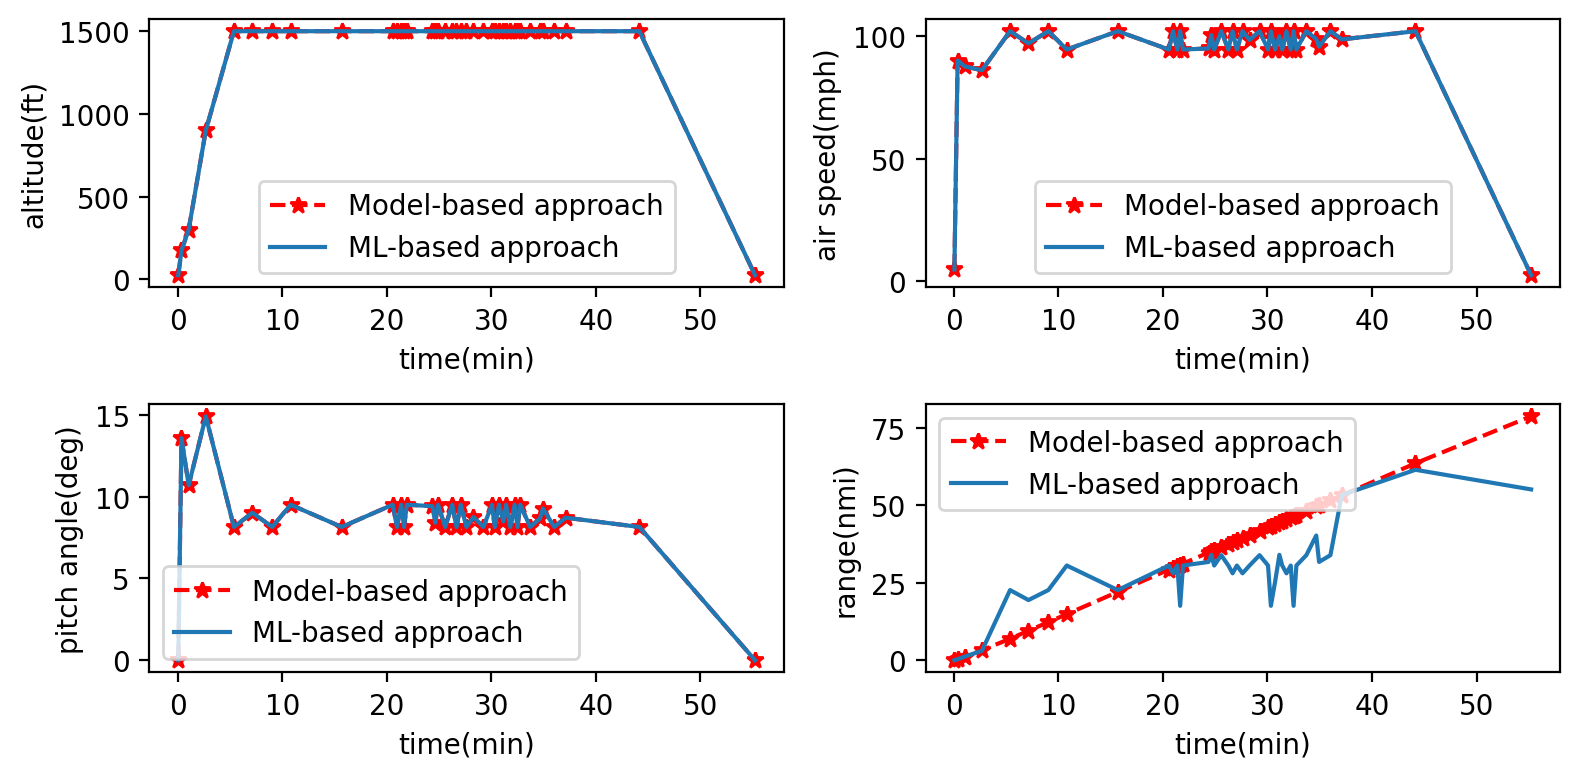

In [49]:
%%time
start_time = time.time()
testX, testY = get_data_for_inference('flight_conditions')
print(testX.shape, testY.shape)
indxes = testY[:,-1]==1
testY = testY[indxes]
testX = testX[indxes]
pred_Y = None
outputs = ['altitude(ft)', 'air speed(mph)', 'pitch angle(deg)', 'range(nmi)','fesibility']
for i in [0,1,2,3]:
    with open('./pickle_files/'+outputs[i]+'_regr_DT.pickle', 'rb') as handle:
        estimator = pickle.load(handle)
        pred_y = estimator.predict(testX)
        pred_Y = pred_y if pred_Y is None else np.vstack((pred_Y, pred_y))
print('Inference Time {}s'.format(time.time()-start_time))
pred_Y = pred_Y.T

x_label = 'time(min)'
y_labels = ['altitude(ft)', 'air speed(mph)', 'pitch angle(deg)', 'range(nmi)','fesibility']
t = testY[:,-2]
true_i = [0,1,2,3]
fig = plt.figure(figsize=(8,4), dpi=200)
for i in range(1,5):
    plt.subplot(2,2,i)
    plt.plot(t, testY[:,true_i[i-1]], 'r*--', label='Model-based approach', )
    plt.plot(t, pred_Y[:,i-1], label='ML-based approach')
    plt.xlabel(x_label)
    plt.ylabel(y_labels[i-1])
    plt.legend()
fig.tight_layout()

## Aerodynamic Coefficients 

(11, 22) (11, 6)
Inference Time 0.03185892105102539s
(11, 6) (11, 4)
CPU times: user 1.51 s, sys: 0 ns, total: 1.51 s
Wall time: 1.38 s


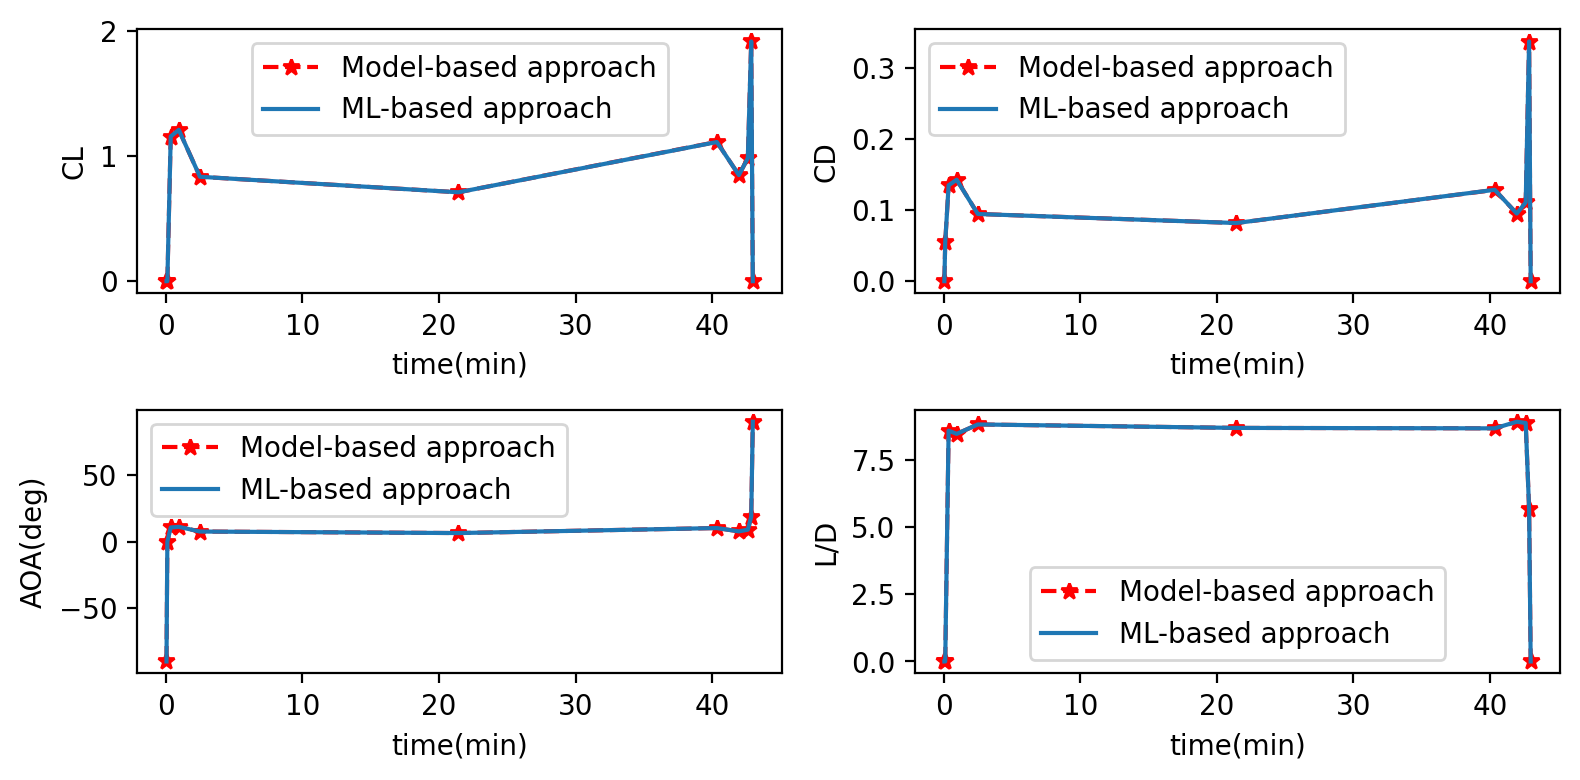

In [52]:
%%time
start_time = time.time()
testX, testY = get_data_for_inference('aerodynamic_coefficients')
print(testX.shape, testY.shape)
indxes = testY[:,-1]==1
testY = testY[indxes]
testX = testX[indxes]
pred_Y = None
outputs = ['CL', 'CD', 'AOA(deg)', 'L_D','fesibility']
for i in [0,1,2,3]:
    with open('./pickle_files/'+outputs[i]+'_regr_DT.pickle', 'rb') as handle:
        estimator = pickle.load(handle)
        pred_y = estimator.predict(testX)
        pred_Y = pred_y if pred_Y is None else np.vstack((pred_Y, pred_y))
print('Inference Time {}s'.format(time.time()-start_time))
pred_Y = pred_Y.T
print(testY.shape, pred_Y.shape)
x_label = 'time(min)'
y_labels = ['CL', 'CD', 'AOA(deg)', 'L/D','fesibility']
t = testY[:,-2]
true_i = [0,1,2,3]
fig = plt.figure(figsize=(8,4), dpi=200)
for i in range(1,5):
    plt.subplot(2,2,i)
    plt.plot(t, testY[:,true_i[i-1]], 'r*--', label='Model-based approach')
    plt.plot(t, pred_Y[:,i-1], label='ML-based approach')
    plt.xlabel(x_label)
    plt.ylabel(y_labels[i-1])
    plt.legend()
fig.tight_layout() 

## Aircraft Electronics 

(12, 22) (12, 11)
Inference Time 0.031127452850341797s
(12, 11) (12, 7)
(24, 22) (24, 11)
Inference Time 0.07402300834655762s
(24, 11) (24, 7)
CPU times: user 634 ms, sys: 0 ns, total: 634 ms
Wall time: 378 ms


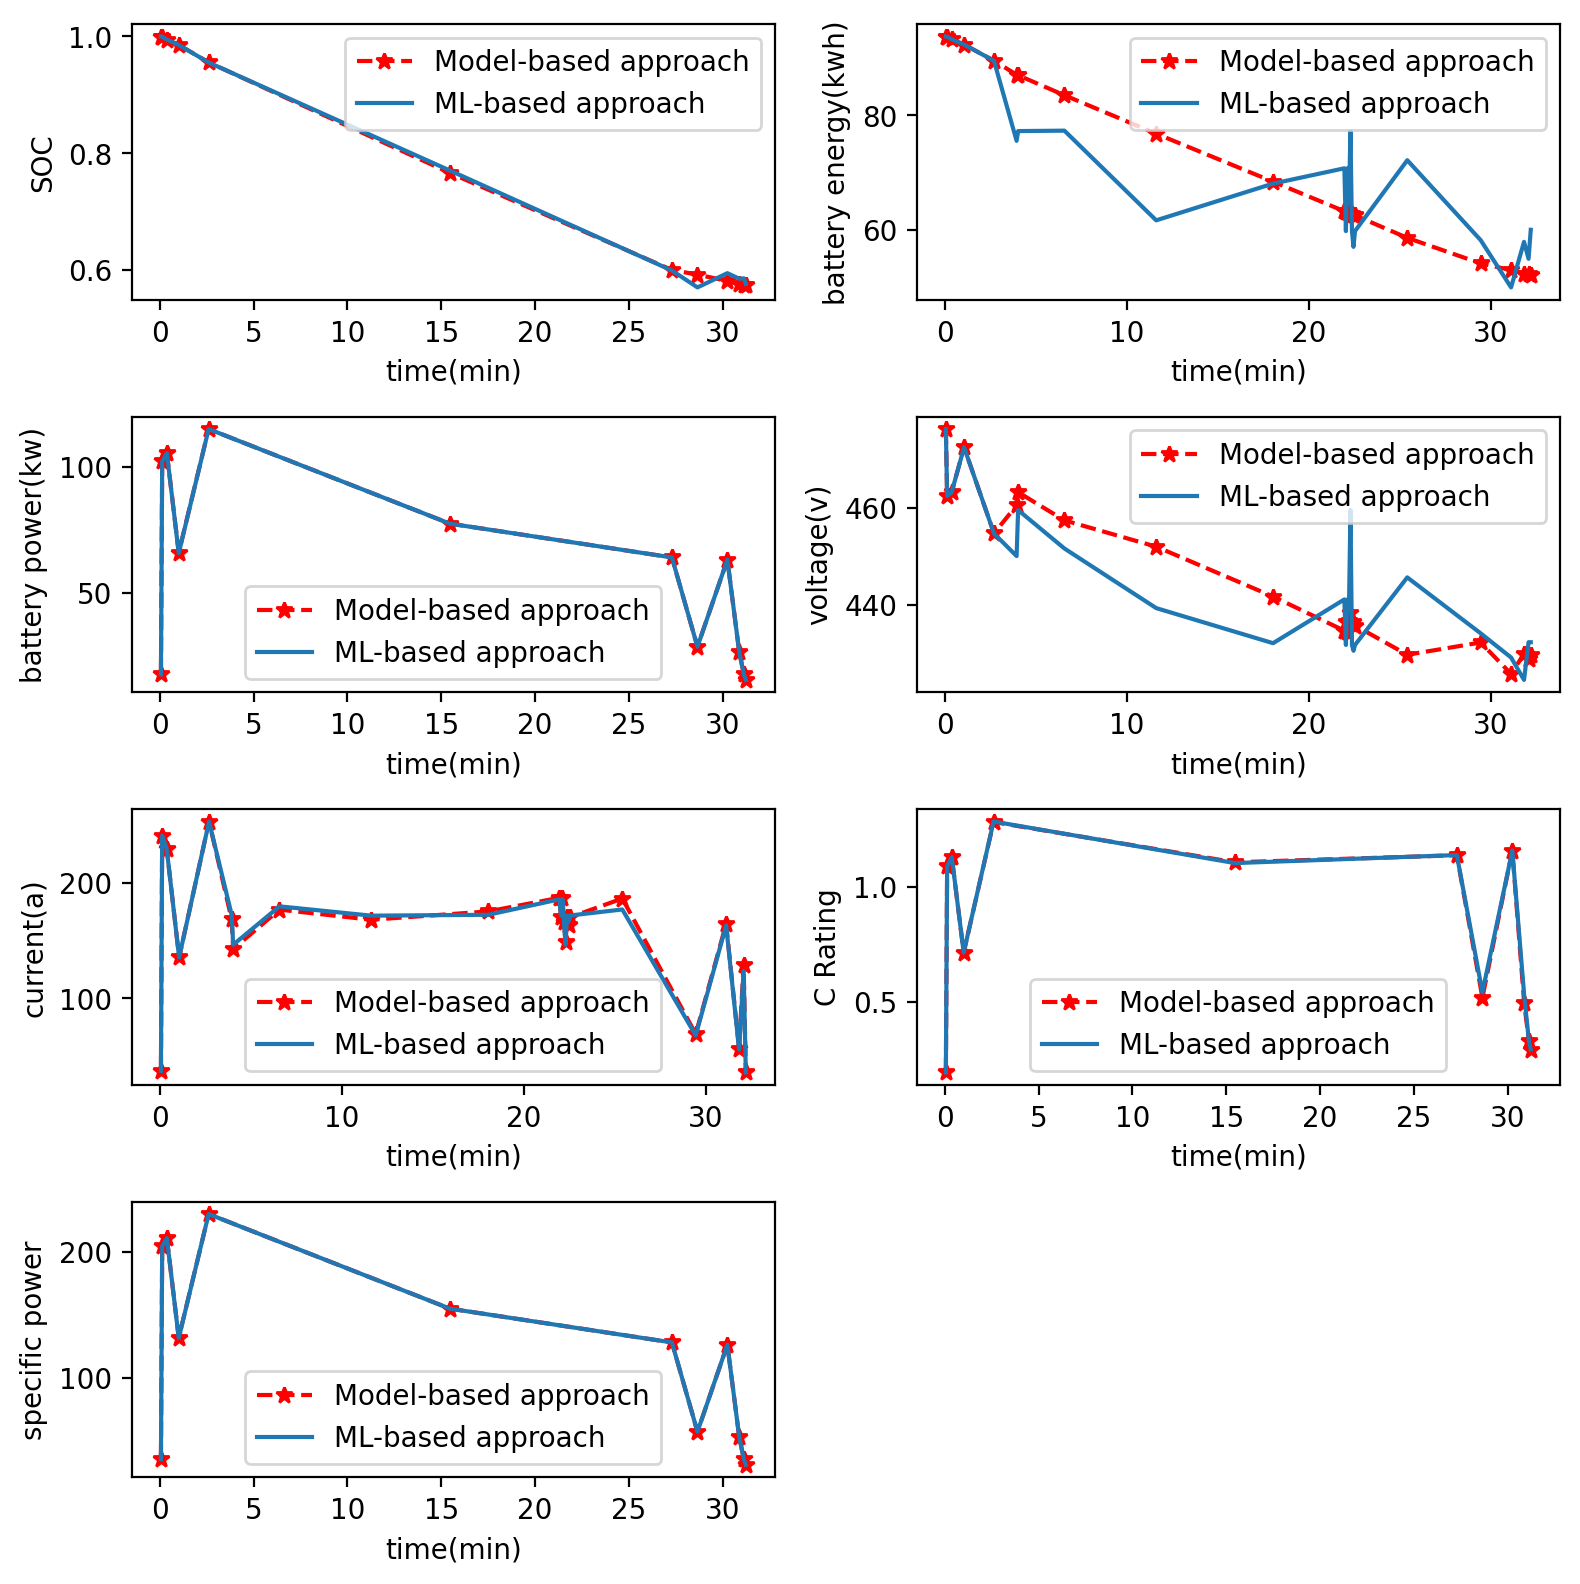

In [172]:
%%time
sets = {965:None,1477:None}

start_time = time.time()
for k in sets:
    
    testX, testY = get_data_for_inference('aircraft_electronics',key=k)
    print(testX.shape, testY.shape)
    indxes = testY[:,-1]==1
    testY = testY[indxes]
    testX = testX[indxes]
    pred_Y = None
    outputs = ['SOC', 'battery energy(kwh)', 'battery power(kw)', 'voltage(v)', 'voltage oc(v)', 'current(a)', 
                'C Rating instant', 'C Rating nominal', 'specific power', 'fesibility']
    for i in [0,1,2,3,5,6,8]:
        with open('./pickle_files/'+outputs[i]+'_regr_DT.pickle', 'rb') as handle:
            estimator = pickle.load(handle)
            pred_y = estimator.predict(testX)
            pred_Y = pred_y if pred_Y is None else np.vstack((pred_Y, pred_y))
    print('Inference Time {}s'.format(time.time()-start_time))  
    pred_Y = pred_Y.T
    print(testY.shape, pred_Y.shape)
    sets[k] = (testY, pred_Y)


x_label = 'time(min)'
y_labels = ['SOC', 'battery energy(kwh)', 'battery power(kw)', 'voltage(v)', 'voltage oc(v)', 'current(a)', 
            'C Rating', 'C Rating nominal', 'specific power', 'fesibility']


t = testY[:,-2]
true_i = [0,1,2,3,5,6,8]
fig = plt.figure(figsize=(8,8), dpi=200)
for i in range(1,len(true_i)+1):
    if true_i[i-1] in [0,2,6,8]:
        testY,pred_Y = sets[965]
    else:
        testY,pred_Y = sets[1477]
    t = testY[:,-2]
    plt.subplot(4,2,i)
    plt.plot(t, testY[:,true_i[i-1]], 'r*--', label='Model-based approach')
    plt.plot(t, pred_Y[:, i-1], label='ML-based approach')
    plt.xlabel(x_label)
    plt.ylabel(y_labels[true_i[i-1]])
    plt.legend()
fig.tight_layout()

## Electric motor and propeller efficiencies 

(11, 22) (11, 18)
Inference Time 0.043543100357055664s
(11, 18) (11, 14)
CPU times: user 668 ms, sys: 172 ms, total: 839 ms
Wall time: 585 ms
Parser   : 1.44 s


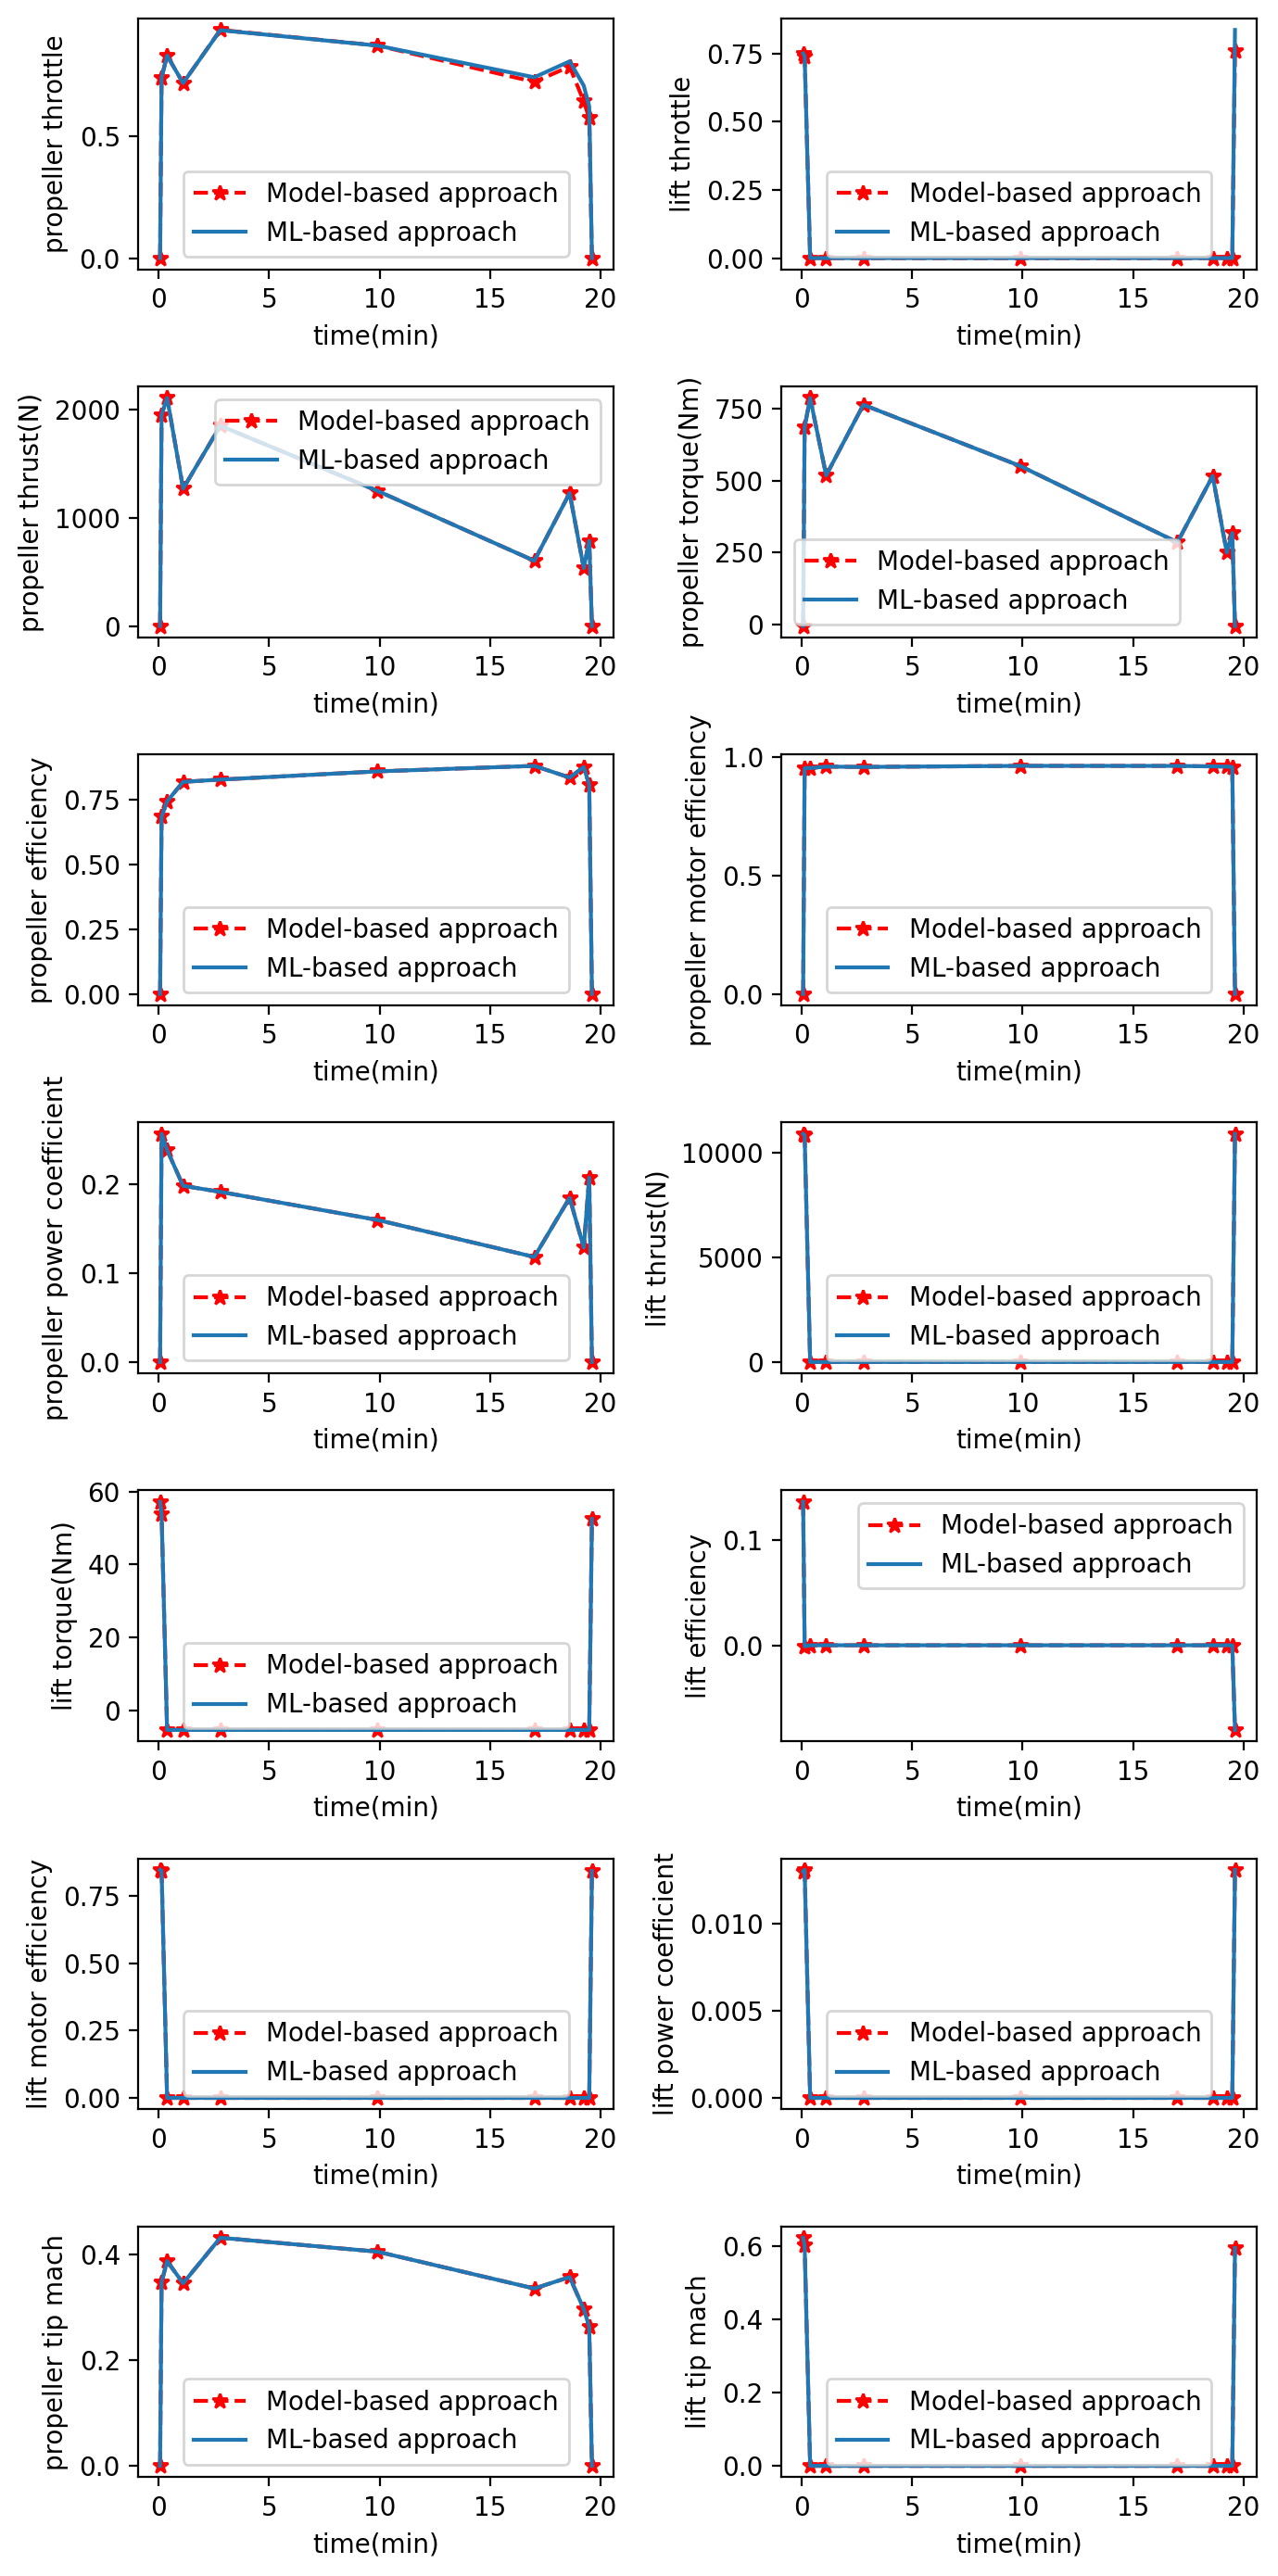

In [73]:
%%time
start_time = time.time()
testX, testY = get_data_for_inference('electric_motor_and_propeller_efficiencies')
print(testX.shape, testY.shape)
pred_Y = None
outputs = ['propeller throttle', 'lift throttle', 'propeller rpm', 'propeller thrust(N)',
            'propeller torque(Nm)', 'propeller efficiency', 'propeller motor efficiency',
            'propeller power coefficient', 'lift rotor rpm', 'lift thrust(N)', 'lift torque(Nm)',
            'lift efficiency', 'lift motor efficiency', 'lift power coefficient', 'propeller tip mach', 
            'lift tip mach', 'fesibility']
for i in [0,1,3,4,5,6,7,9,10,11,12,13,14,15]:
    with open('./pickle_files/'+outputs[i]+'_regr_DT.pickle', 'rb') as handle:
        estimator = pickle.load(handle)
        pred_y = estimator.predict(testX)
        pred_Y = pred_y if pred_Y is None else np.vstack((pred_Y, pred_y))
print('Inference Time {}s'.format(time.time()-start_time))
pred_Y = pred_Y.T
print(testY.shape, pred_Y.shape)
x_label = 'time(min)'
y_labels = ['propeller throttle', 'lift throttle', 'propeller rpm', 'propeller thrust(N)',
            'propeller torque(Nm)', 'propeller efficiency', 'propeller motor efficiency',
            'propeller power coefficient', 'lift rotor rpm', 'lift thrust(N)', 'lift torque(Nm)',
            'lift efficiency', 'lift motor efficiency', 'lift power coefficient', 'propeller tip mach', 
            'lift tip mach', 'fesibility']
t = testY[:,-2]
true_i = [0,1,3,4,5,6,7,9,10,11,12,13,14,15]
fig = plt.figure(figsize=(7,14), dpi=200)
for i in range(1,len(true_i)+1):
    plt.subplot(7,2,i)
    plt.plot(t, testY[:,true_i[i-1]], 'r*--', label='Model-based approach')
    plt.plot(t, pred_Y[:, i-1], label='ML-based approach')
    plt.xlabel(x_label)
    plt.ylabel(y_labels[true_i[i-1]])
    plt.legend()
fig.tight_layout()

## Inferencing from trained LSTM (range, battery energy, voltage and current)

CPU times: user 4.08 s, sys: 1.8 s, total: 5.88 s
Wall time: 5.28 s


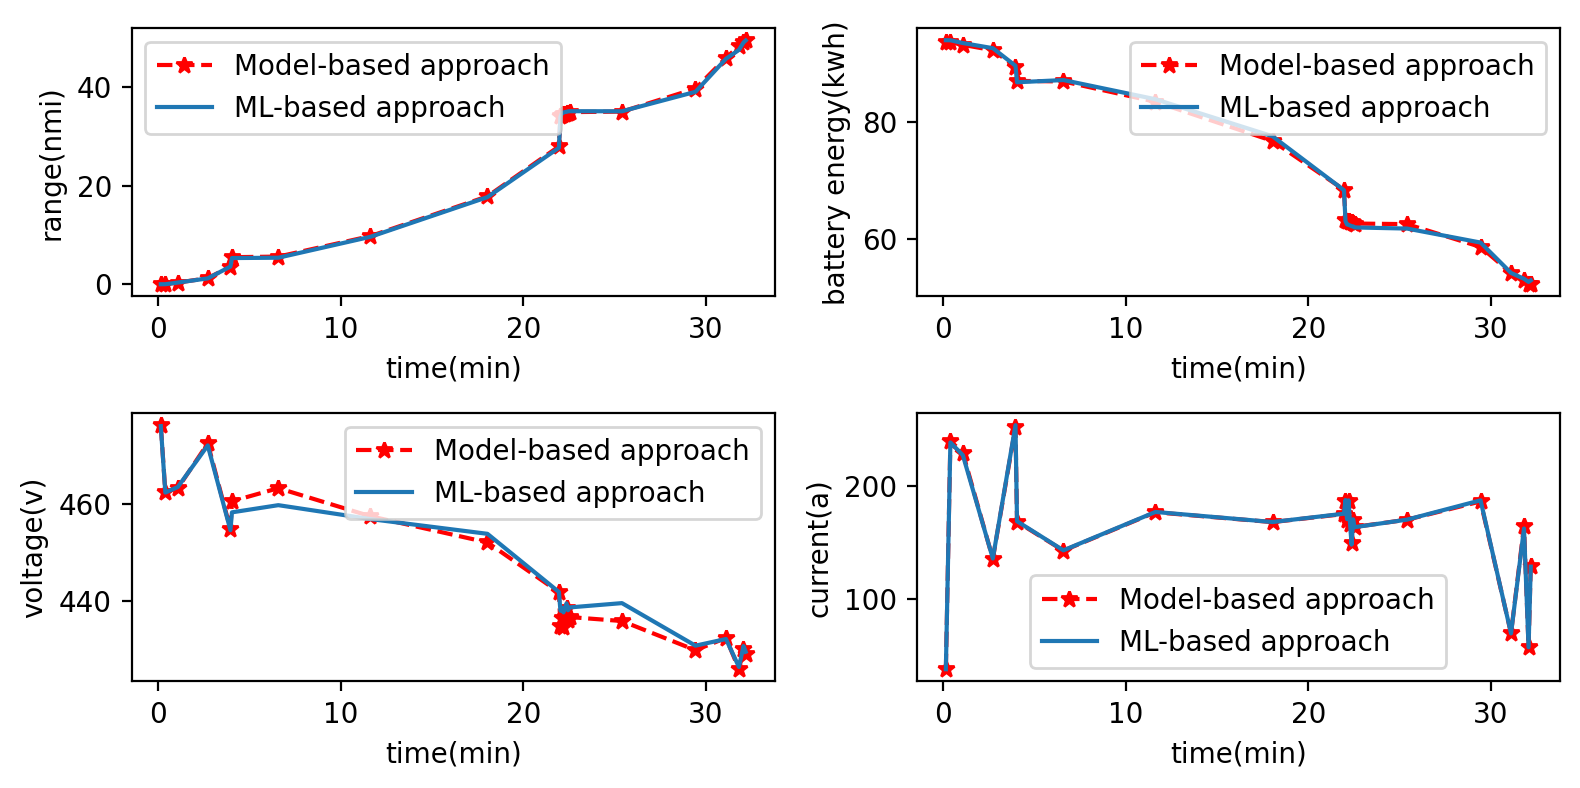

In [218]:
%%time

performance_metrics = {'flight_conditions':[3], # range
                       'aircraft_electronics':[1, 3, 5], # battery energy, voltage, current
                       }
x_label = 'time(min)'
y_labels = ['range(nmi)', 'battery energy(kwh)', 'voltage(v)', 'current(a)']
subplot_idx = 1
custom_fn = mape_loss_fn
key = 1477
fig = plt.figure(figsize=(8,4), dpi=200)
for performance_metric in performance_metrics:
    for idx in performance_metrics[performance_metric]:
        model = tf.keras.models.load_model(model_dir+trained_models_name[subplot_idx-1], 
                                           custom_objects={'mape_loss_fn':custom_fn})
        
        testX, testY, key = get_data_for_lstm_inference(performance_metric, idx, key)
        if testX is not None:
            t = testY[:,-2]
            t = t[1:]
            testY = testY[:,idx].reshape((-1,1))
            
            dataset = timeseries_dataset_from_array(testX, 
                                                    testY, 
                                                    sequence_length=2,
                                                    batch_size=128)
            for batch in dataset:
                testX, testY = batch
            outputs = model.predict(testX)
            y_true = testY
            y_pred = outputs

            plt.subplot(2,2,subplot_idx)
            plt.plot(t, y_true, 'r*--', label='Model-based approach')
            plt.plot(t, y_pred, label='ML-based approach')
            plt.xlabel(x_label)
            plt.ylabel(y_labels[subplot_idx-1])
#             if performance_metric == 'aircraft_electronics' and idx == 1:
#                 plt.ylim([0,120])
#             else:
#                 pass
            plt.legend()
            subplot_idx += 1
        else:
            print("No valid test data found!!!")
fig.tight_layout()